## BBM 409 - Assignment 4: Bird Species Classification


## Part 0: Data Loading, Preprocessing, and Visualization

### Part 0.1: Imports and Global Parameters

In [2]:

# %% Setup: Imports and Global Parameters
import os
import cv2 # OpenCV for image manipulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# tensorflow.keras.utils.to_categorical for one-hot encoding, can be added later if needed for NNs
import random
import pandas as pd
from sklearn.manifold import TSNE # For t-SNE visualization
from sklearn.preprocessing import StandardScaler # For t-SNE and feature scaling
import time # For retrying image reads
from PIL import Image # For robust image opening and format checks

# --- USER CONFIGURABLE PARAMETERS ---
# !!! IMPORTANT: SET THIS TO YOUR DATASET PATH !!!
DATASET_BASE_DIR = 'Birds_25'  # Path to your 'Birds_25' directory

# Image dimensions for resizing and storing in memory (BGR format)
IMG_WIDTH = 28 #
IMG_HEIGHT = 28 #
IMG_CHANNELS = 3 # Images will be stored as BGR

NUM_CLASSES = 25 # As per the assignment
# --- END USER CONFIGURABLE PARAMETERS ---

TRAIN_DIR = os.path.join(DATASET_BASE_DIR, 'train') #
VALID_DIR = os.path.join(DATASET_BASE_DIR, 'valid') #

print(f"Image dimensions for in-memory storage: {IMG_WIDTH}x{IMG_HEIGHT} (BGR)")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Training directory: {TRAIN_DIR}")
print(f"Validation directory (original): {VALID_DIR}")


Image dimensions for in-memory storage: 28x28 (BGR)
Number of classes: 25
Training directory: Birds_25/train
Validation directory (original): Birds_25/valid


### Part 0.2: Discover Species and Collect Initial Image Paths


In [3]:
species_list = []
if os.path.exists(TRAIN_DIR):
    species_list = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]) #
else:
    print(f"ERROR: Training directory not found at '{TRAIN_DIR}'. Please check DATASET_BASE_DIR.")
    raise FileNotFoundError(f"Training directory not found: {TRAIN_DIR}")

if not species_list:
    print("ERROR: Species list is empty. Ensure dataset is structured correctly.")
else:
    print(f"Found {len(species_list)} species. First 5: {species_list[:5]}...") #
    if len(species_list) != NUM_CLASSES:
        print(f"Warning: Discovered {len(species_list)} species, but NUM_CLASSES is set to {NUM_CLASSES}. Will use discovered count: {len(species_list)}")
        NUM_CLASSES = len(species_list)

all_original_train_paths = [] #
all_original_train_labels_str = [] #
all_original_valid_paths = [] #
all_original_valid_labels_str = [] #

for species_name in species_list:
    species_train_dir = os.path.join(TRAIN_DIR, species_name) #
    if os.path.isdir(species_train_dir):
        for img_file in os.listdir(species_train_dir): #
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')): # Added more common extensions
                all_original_train_paths.append(os.path.join(species_train_dir, img_file)) #
                all_original_train_labels_str.append(species_name) #

    species_valid_dir = os.path.join(VALID_DIR, species_name) #
    if os.path.isdir(species_valid_dir):
        for img_file in os.listdir(species_valid_dir): #
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')): #
                all_original_valid_paths.append(os.path.join(species_valid_dir, img_file)) #
                all_original_valid_labels_str.append(species_name) #

print(f"\nTotal original training image paths collected: {len(all_original_train_paths)}") #
print(f"Total original validation image paths collected: {len(all_original_valid_paths)}") #


Found 25 species. First 5: ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna']...

Total original training image paths collected: 30000
Total original validation image paths collected: 7500


### Part 0.3: Encode Labels and Prepare 80-10-10 Split Image Paths


In [4]:

# %% [markdown]
# This step prepares the lists of paths and numerically encoded labels for each dataset split.
# %% Step 2 Code
if not all_original_train_labels_str:
    print("ERROR: No training labels found from Step 1. Cannot proceed with label encoding.")
    # Handle error or ensure Step 1 ran correctly and found images.
    label_encoder = LabelEncoder() # Initialize to prevent later errors, but it won't be fit.
    label_mapping = {}
    all_original_train_labels_encoded = np.array([])
    all_original_valid_labels_encoded = np.array([])
else:
    label_encoder = LabelEncoder() #
    all_original_train_labels_encoded = label_encoder.fit_transform(all_original_train_labels_str) #
    if all_original_valid_labels_str: # Only transform if validation labels exist
         all_original_valid_labels_encoded = label_encoder.transform(all_original_valid_labels_str) #
    else:
        all_original_valid_labels_encoded = np.array([], dtype=int) # Ensure it's an empty array of appropriate type
        print("Warning: No original validation labels found to encode.")

    label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)} #
    print("\nLabel mapping (numerical_label: species_name):") #
    for i in range(min(5, len(label_mapping))): # Print first 5
        print(f"{i}: {label_mapping[i]}")
    if len(label_mapping) > 5: print("...") #
    
    # Update NUM_CLASSES if label_encoder found a different number of classes than initially set
    if len(label_encoder.classes_) != NUM_CLASSES and len(label_encoder.classes_) > 0:
        print(f"Warning: Number of classes from LabelEncoder ({len(label_encoder.classes_)}) differs from NUM_CLASSES ({NUM_CLASSES}). Updating NUM_CLASSES to {len(label_encoder.classes_)}.")
        NUM_CLASSES = len(label_encoder.classes_)
    elif len(label_encoder.classes_) == 0 :
        print("ERROR: LabelEncoder found 0 classes. Dataset might be empty or incorrectly structured.")
        NUM_CLASSES = 0


# Training set paths and labels (as per assignment: "1,200 for training")
X_train_paths = all_original_train_paths #
y_train_labels_encoded_np = np.array(all_original_train_labels_encoded) # Convert to NumPy array here for consistency

# Validation and Test set paths and labels (as per assignment: "split each validation set into half randomly 
# to separate as 150 for test and 150 for validation")
X_val_paths = [] #
y_val_labels_encoded_list = [] # Using list to append, then convert to np.array
X_test_paths = [] #
y_test_labels_encoded_list = []

if all_original_valid_paths: # Proceed only if there are validation paths
    original_valid_paths_np = np.array(all_original_valid_paths) #
    original_valid_labels_np = np.array(all_original_valid_labels_encoded) #

    for class_idx in range(NUM_CLASSES): # Iterate up to the effective NUM_CLASSES
        class_paths = original_valid_paths_np[original_valid_labels_np == class_idx] #
        
        if len(class_paths) == 0:
            # This case should be rare if dataset is consistent but good to handle
            print(f"Warning: No original validation images found for class index {class_idx} ({label_mapping.get(class_idx, 'Unknown')}).")
            continue

        random.shuffle(class_paths) # Shuffle paths for this class
        
        # Assignment PDF says: "split each validation set into half randomly 
        # to separate as 150 for test and 150 for validation".
        # This implies the original 'valid' set for each class had 300 images.
        # We will split the available images per class 50/50.
        
        split_point = len(class_paths) // 2 #
        
        # PDF: "80-10-10 ratio for training, testing, and validation purposes with respect to order of ratios."
        # This often means Train-Val-Test, but the specific instruction for splitting 'valid' is "150 for test and 150 for validation".
        # We'll assign the first half to 'test' and the second to 'validation' to match this specific instruction's order.
        
        X_test_paths.extend(class_paths[:split_point]) #
        y_test_labels_encoded_list.extend([class_idx] * split_point) #
        
        X_val_paths.extend(class_paths[split_point:]) #
        y_val_labels_encoded_list.extend([class_idx] * (len(class_paths) - split_point)) #
else:
    print("Warning: 'all_original_valid_paths' is empty. Validation and Test sets will be empty.")

print(f"\n--- Dataset Split Path Counts (Following PDF: Train from 'train' dir, Test/Val from splitting 'valid' dir) ---") #
print(f"Target training image paths: {len(X_train_paths)}") #
print(f"Target test image paths: {len(X_test_paths)}") #
print(f"Target validation image paths: {len(X_val_paths)}") #

# Convert label lists to NumPy arrays
y_train_labels_encoded_np = np.array(y_train_labels_encoded_np) # Already was, but ensures it is np.array
y_val_labels_encoded_np = np.array(y_val_labels_encoded_list) #
y_test_labels_encoded_np = np.array(y_test_labels_encoded_list) #



Label mapping (numerical_label: species_name):
0: Asian-Green-Bee-Eater
1: Brown-Headed-Barbet
2: Cattle-Egret
3: Common-Kingfisher
4: Common-Myna
...

--- Dataset Split Path Counts (Following PDF: Train from 'train' dir, Test/Val from splitting 'valid' dir) ---
Target training image paths: 30000
Target test image paths: 3750
Target validation image paths: 3750


### Part 0.4: Data Preprocessing (Image Loading, Resizing, and Storage in Memory)

In [5]:

# %% [markdown]
# ## Step 3: Efficient Image Loading, Resizing, and Storage (BGR format in Memory)
# This step reads all images from the split paths ONCE, resizes them, 
# and stores them in memory as BGR NumPy arrays. 
# It also filters labels for images that couldn't be loaded/processed robustly.
# Normalization (e.g., to [0,1]) will be applied later if a specific model requires it.
# For traditional feature extractors (Part 1), we'll often use the 0-255 BGR or Grayscale images derived from these.

# %% Step 3 Code
print("--- Loading and Resizing All Images (BGR format) into Memory & Filtering Labels ---")

def load_resize_and_filter_bgr_efficiently(image_paths, original_labels_np, target_width, target_height, max_retries=3, retry_delay_seconds=1):
    """
    Loads images from paths, resizes to target_width x target_height, stores as BGR.
    Retries reading an image if it fails, up to max_retries using PIL for robustness.
    Filters out images that cannot be loaded/processed and their corresponding labels.
    Returns NumPy arrays of loaded BGR images, filtered labels, and successfully loaded paths.
    """
    loaded_images_bgr_list = []
    filtered_labels_list = []
    successfully_loaded_paths_list = []
    skipped_count = 0
    
    if not image_paths: # Handle empty image_paths list
        print("Warning: Input image_paths list is empty for efficient loading.")
        # Return empty arrays with appropriate shapes if possible, or just empty arrays
        return np.empty((0, target_height, target_width, IMG_CHANNELS), dtype=np.uint8), \
               np.array([], dtype=original_labels_np.dtype if original_labels_np.size > 0 else int), \
               []

    total_paths = len(image_paths)
    print(f"Attempting to load and resize {total_paths} images to ({target_width}x{target_height})...")
    
    for i, img_path in enumerate(image_paths):
        img_bgr = None
        for attempt in range(max_retries):
            try:
                pil_img = Image.open(img_path)
                pil_img_rgb = pil_img.convert('RGB') 
                img_bgr = cv2.cvtColor(np.array(pil_img_rgb), cv2.COLOR_RGB2BGR)
                
                if img_bgr is not None:
                    break 
            except FileNotFoundError:
                print(f"ERROR (Attempt {attempt+1}/{max_retries}): File not found {img_path}. Skipping this image.")
                img_bgr = None 
                break 
            except Exception as e_read:
                print(f"Warning (Attempt {attempt+1}/{max_retries}): Error reading/converting image {img_path}: {e_read}. Retrying in {retry_delay_seconds}s...")
                time.sleep(retry_delay_seconds)
        
        if img_bgr is None:
            print(f"ERROR: Failed to load/convert image {img_path} after {max_retries} attempts, skipping.")
            skipped_count += 1
            continue
        
        try:
            # Ensure image has 3 channels after conversion
            if len(img_bgr.shape) != 3 or img_bgr.shape[2] != 3:
                print(f"Warning: Image {img_path} does not have 3 channels after conversion (shape: {img_bgr.shape}), attempting to force BGR.")
                if len(img_bgr.shape) == 2: 
                    img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2BGR)
                elif img_bgr.shape[2] == 1: 
                     img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2BGR)
                elif img_bgr.shape[2] == 4: 
                    img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_BGRA2BGR)
                else:
                    raise ValueError(f"Unsupported number of channels: {img_bgr.shape[2]}")

            img_bgr_resized = cv2.resize(img_bgr, (target_width, target_height), interpolation=cv2.INTER_AREA)
            loaded_images_bgr_list.append(img_bgr_resized)
            filtered_labels_list.append(original_labels_np[i])
            successfully_loaded_paths_list.append(img_path)
        except Exception as e_proc:
            print(f"Error resizing/processing image {img_path} (shape: {img_bgr.shape if img_bgr is not None else 'None'}, dtype: {img_bgr.dtype if img_bgr is not None else 'None'}): {e_proc}, skipping.")
            skipped_count += 1
            continue

        if (i + 1) % 250 == 0 or (i + 1) == total_paths: 
            print(f"  Processed {i+1}/{total_paths} image paths for this set.")
            
    print(f"Finished loading for this set. Successfully loaded/resized {len(loaded_images_bgr_list)} images. Skipped {skipped_count} images.")
    
    # Convert lists to NumPy arrays, ensuring correct dtype and shape for empty lists
    final_images_array = np.array(loaded_images_bgr_list, dtype=np.uint8) if loaded_images_bgr_list else np.empty((0, target_height, target_width, IMG_CHANNELS), dtype=np.uint8)
    final_labels_array = np.array(filtered_labels_list, dtype=original_labels_np.dtype if original_labels_np.size > 0 else int) if filtered_labels_list else np.array([], dtype=original_labels_np.dtype if original_labels_np.size > 0 else int)
    
    return final_images_array, final_labels_array, successfully_loaded_paths_list

# --- Load all images into memory. These will be used by subsequent parts. ---
# The *_final variables will hold the actual BGR image data (0-255 range) and their filtered labels.
# X_train_paths etc. are from Step 2 Code cell

if 'X_train_paths' not in globals() or not X_train_paths:
    print("ERROR: X_train_paths is not defined or empty. Please run Step 1 and Step 2 first.")
    # Initialize to prevent errors if subsequent cells are run accidentally
    X_train_images_bgr, y_train_final, X_train_paths_final = np.array([]), np.array([]), []
    X_val_images_bgr, y_val_final, X_val_paths_final = np.array([]), np.array([]), []
    X_test_images_bgr, y_test_final, X_test_paths_final = np.array([]), np.array([]), []
else:
    X_train_images_bgr, y_train_final, X_train_paths_final = load_resize_and_filter_bgr_efficiently(X_train_paths, y_train_labels_encoded_np, IMG_WIDTH, IMG_HEIGHT)
    X_val_images_bgr, y_val_final, X_val_paths_final = load_resize_and_filter_bgr_efficiently(X_val_paths, y_val_labels_encoded_np, IMG_WIDTH, IMG_HEIGHT)
    X_test_images_bgr, y_test_final, X_test_paths_final = load_resize_and_filter_bgr_efficiently(X_test_paths, y_test_labels_encoded_np, IMG_WIDTH, IMG_HEIGHT)

print("\n--- Final Data Shapes After Loading Images into Memory ---")
print(f"X_train_images_bgr shape: {X_train_images_bgr.shape}, y_train_final shape: {y_train_final.shape}")
print(f"X_val_images_bgr shape: {X_val_images_bgr.shape}, y_val_final shape: {y_val_final.shape}")
print(f"X_test_images_bgr shape: {X_test_images_bgr.shape}, y_test_final shape: {y_test_final.shape}")

# Update NUM_CLASSES and target_names_part1 based on actual unique labels found AFTER filtering
# This is crucial if some classes were entirely skipped due to loading errors.
if y_train_final.size > 0:
    # Concatenate all filtered labels to find the true set of classes present in the loaded data
    all_loaded_labels_list = []
    if y_train_final.size > 0: all_loaded_labels_list.append(y_train_final)
    if y_val_final.size > 0: all_loaded_labels_list.append(y_val_final)
    if y_test_final.size > 0: all_loaded_labels_list.append(y_test_final)
    
    if all_loaded_labels_list: # If any labels exist after filtering
        all_loaded_labels = np.concatenate(all_loaded_labels_list, axis=0)
        unique_loaded_labels = np.unique(all_loaded_labels)
        actual_num_classes_loaded = len(unique_loaded_labels)
    else: # No labels loaded at all
        actual_num_classes_loaded = 0
        unique_loaded_labels = np.array([])
        print("CRITICAL WARNING: No labels loaded into y_train_final, y_val_final, or y_test_final. Dataset might be empty or all images failed to load.")

    if actual_num_classes_loaded != NUM_CLASSES:
        print(f"INFO: Number of unique labels in all loaded data ({actual_num_classes_loaded}) "
              f"differs from initial NUM_CLASSES ({NUM_CLASSES}). Updating NUM_CLASSES to {actual_num_classes_loaded}.")
        NUM_CLASSES = actual_num_classes_loaded
    
    if 'label_mapping' in globals():
        # Create target names based on labels that are actually present and in label_mapping
        target_names_part1 = [label_mapping.get(i, str(i)) for i in sorted(list(unique_loaded_labels))]
        if len(target_names_part1) != actual_num_classes_loaded and actual_num_classes_loaded > 0:
             print(f"Warning: Mismatch in target_names_part1 generation ({len(target_names_part1)}) and actual_num_classes_loaded ({actual_num_classes_loaded}). Some labels might not be in label_mapping. Using sorted unique labels as strings for missing ones.")
             # This line ensures target_names_part1 has the correct length, using string of label if not in mapping
             target_names_part1 = [label_mapping.get(i, str(i)) for i in sorted(list(unique_loaded_labels))]
    else: # Fallback if label_mapping is not defined
        target_names_part1 = [str(i) for i in sorted(list(unique_loaded_labels))]
        if actual_num_classes_loaded > 0 : print("Warning: label_mapping not found. Using sorted unique numerical labels for classification report target names.")
        else: print("Warning: label_mapping not found and no labels loaded to derive target_names.")

    print(f"Effective NUM_CLASSES for reports: {NUM_CLASSES}")
    print(f"Target names for reports (first 5 if available): {target_names_part1[:5] if target_names_part1 else 'N/A'}")

else: # Handle case where y_train_final itself is empty (meaning no training images loaded)
    print("ERROR: y_train_final is empty after loading. Cannot reliably set NUM_CLASSES or target_names_part1. This indicates a major issue with training data loading.")
    NUM_CLASSES = 0 # Set to 0 if no training data, to prevent errors in later cells expecting NUM_CLASSES
    target_names_part1 = []



--- Loading and Resizing All Images (BGR format) into Memory & Filtering Labels ---
Attempting to load and resize 30000 images to (28x28)...
  Processed 250/30000 image paths for this set.
  Processed 500/30000 image paths for this set.
  Processed 750/30000 image paths for this set.
  Processed 1000/30000 image paths for this set.
  Processed 1250/30000 image paths for this set.
  Processed 1500/30000 image paths for this set.
  Processed 1750/30000 image paths for this set.
  Processed 2000/30000 image paths for this set.
  Processed 2250/30000 image paths for this set.
  Processed 2500/30000 image paths for this set.
  Processed 2750/30000 image paths for this set.
  Processed 3000/30000 image paths for this set.
  Processed 3250/30000 image paths for this set.
  Processed 3500/30000 image paths for this set.
  Processed 3750/30000 image paths for this set.
  Processed 4000/30000 image paths for this set.
  Processed 4250/30000 image paths for this set.
  Processed 4500/30000 image 

### Part 0.5: Visualization Functions

In [6]:

# %% [markdown]
# ## Step 4: Visualization Functions (Adapted for In-Memory BGR Images)
# These functions will now primarily operate on the in-memory BGR image arrays 
# (`X_train_images_bgr`, etc.) and their corresponding filtered labels (`y_train_final`, etc.).
# Normalization to [0,1] and BGR->RGB conversion for display are handled within these functions as needed.

# %% Step 4 Code
# Keep your existing visualization functions (display_sample_images_from_paths, 
# plot_class_distribution, show_downscaling_effect_from_path, 
# display_average_processed_images, plot_color_histograms_for_raw_image, 
# plot_tsne_visualization_of_processed) from your notebook's "Step 4 Code" cell.
# I will slightly adapt them below to ensure they primarily use the in-memory BGR arrays.
# The original `load_raw_image_from_path` and `apply_model_preprocessing` are less needed now
# as images are pre-loaded and pre-resized, but `apply_model_preprocessing` might still be useful
# if specific models in later parts need normalized [0,1] RGB input.

def display_sample_images_from_memory(image_array_bgr, numeric_labels_list, label_mapping_dict,
                                   num_samples_per_class=3, num_classes_to_display=5, title_prefix="Sample Loaded"):
    """Displays sample images from an in-memory BGR NumPy array."""
    if image_array_bgr.size == 0 or not numeric_labels_list.size:
        print(f"Image array or labels list is empty for '{title_prefix}' display.")
        return

    # Group images by class using their indices
    images_by_class_indices = {}
    for idx, label_numeric in enumerate(numeric_labels_list):
        if label_numeric not in images_by_class_indices:
            images_by_class_indices[label_numeric] = []
        images_by_class_indices[label_numeric].append(idx)

    unique_labels_available = list(images_by_class_indices.keys())
    if not unique_labels_available: 
        print(f"No unique labels available for '{title_prefix}' display.")
        return

    selected_labels_numeric = random.sample(unique_labels_available, min(num_classes_to_display, len(unique_labels_available)))

    # Adjust subplot layout based on num_samples_per_class
    num_rows = len(selected_labels_numeric)
    num_cols = num_samples_per_class
    plt.figure(figsize=(3 * num_cols, 3.5 * num_rows)) # Adjusted figsize for potentially long titles
    plot_idx = 1
    for label_numeric in selected_labels_numeric:
        class_name = label_mapping_dict.get(label_numeric, f"Label {label_numeric}")
        class_image_indices = images_by_class_indices.get(label_numeric, [])
        if not class_image_indices: continue 
        
        sample_indices = random.sample(class_image_indices, min(num_samples_per_class, len(class_image_indices)))
        
        for i, img_idx in enumerate(sample_indices):
            if plot_idx > num_rows * num_cols: break # Avoid plotting more than subplots
            plt.subplot(num_rows, num_cols, plot_idx)
            img_bgr_to_display = image_array_bgr[img_idx]
            img_rgb_to_display = cv2.cvtColor(img_bgr_to_display, cv2.COLOR_BGR2RGB) 
            plt.imshow(img_rgb_to_display)
            # Truncate long class names if necessary
            display_class_name = (class_name[:20] + '...') if len(class_name) > 23 else class_name
            plt.title(f"{title_prefix}: {display_class_name}\n({img_rgb_to_display.shape[1]}x{img_rgb_to_display.shape[0]})", fontsize=9)
            plt.axis('off')
            plot_idx += 1
    plt.suptitle(f"{title_prefix} Images Per Class (from Memory)", fontsize=16, y=1.0 if num_rows <=1 else 0.98 + (0.02 * (6-num_rows) if num_rows < 6 else 0)) # Adjust suptitle y
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

def plot_class_distribution(y_numeric_list, label_mapping_dict, dataset_name="Dataset"): #
    """Plots class distribution. y_numeric_list should be the filtered labels."""
    if not isinstance(y_numeric_list, np.ndarray) or y_numeric_list.size == 0:
        print(f"Label array for {dataset_name} is empty or not a NumPy array.")
        return
        
    unique_labels, counts = np.unique(y_numeric_list, return_counts=True) #
    
    # Use actual labels present in the data for class names
    class_names = [label_mapping_dict.get(label, f"Class {label}") for label in unique_labels] #
    
    df_counts = pd.DataFrame({'Species': class_names, 'Count': counts}).sort_values('Species') #

    plt.figure(figsize=(max(14, len(class_names)*0.5), 8)) # Dynamically adjust width
    sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis") #
    plt.title(f'Class Distribution in {dataset_name} (Total: {sum(counts)} images after filtering)', fontsize=15) #
    plt.xlabel('Bird Species', fontsize=12) #
    plt.ylabel('Number of Samples', fontsize=12) #
    # Adjust rotation and font size for better readability if many classes
    plt.xticks(rotation=60 if len(class_names) > 15 else 45, 
               ha="right", 
               fontsize=min(10, 200.0/len(class_names) if len(class_names) > 0 else 10)) #
    plt.grid(axis='y', linestyle='--', alpha=0.7) #
    plt.tight_layout() #
    plt.show() #

def show_downscaling_effect_from_memory_and_path(in_memory_bgr_image_resized, original_image_path, target_width, target_height):
    """
    Shows original image (read from path for true original dimensions) vs. 
    the resized version stored in memory (and its normalized version for display).
    """
    raw_img_for_display_rgb = None
    original_dims_str = "(Original Dim. Unknown - Path Error)"
    if original_image_path and os.path.exists(original_image_path):
        try:
            pil_img_orig = Image.open(original_image_path)
            raw_img_for_display_rgb = np.array(pil_img_orig.convert('RGB'))
            original_dims_str = f"({raw_img_for_display_rgb.shape[1]}x{raw_img_for_display_rgb.shape[0]})"
        except Exception as e:
            print(f"Could not load original image from path {original_image_path} for downscaling demo: {e}")
            
    if in_memory_bgr_image_resized is None or in_memory_bgr_image_resized.size == 0:
        print("In-memory resized image is not available for downscaling demo.")
        if raw_img_for_display_rgb is None: return
        plt.figure(figsize=(6, 6))
        plt.imshow(raw_img_for_display_rgb)
        plt.title(f'Original Image (Failed to compare with in-memory)\n{original_dims_str}')
        plt.axis('off'); plt.show()
        return

    img_rgb_resized_from_memory = cv2.cvtColor(in_memory_bgr_image_resized, cv2.COLOR_BGR2RGB)
    processed_img_for_display_normalized = img_rgb_resized_from_memory.astype('float32') / 255.0

    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # Simpler layout
    if raw_img_for_display_rgb is not None:
        axes[0].imshow(raw_img_for_display_rgb)
    else: 
        axes[0].imshow(img_rgb_resized_from_memory) 
        original_dims_str = f"(Displaying In-Memory Resized: {target_width}x{target_height})"
    axes[0].set_title(f'Original-Like Image\n{original_dims_str}')
    axes[0].axis('off')

    axes[1].imshow(processed_img_for_display_normalized) 
    axes[1].set_title(f'Stored & Resized ({target_width}x{target_height})\nDisplayed as RGB Normalized')
    axes[1].axis('off')
    fig.suptitle("Image State: Original-Like vs. Stored & Displayed", fontsize=14, y=1.0) # Adjusted y for suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

def display_average_images_from_memory(X_images_bgr, y_numeric_list, label_mapping_dict, num_classes_to_display=5):
    """Displays average images from an in-memory BGR NumPy array."""
    if X_images_bgr.size == 0 or not y_numeric_list.size:
        print("Image array or labels are empty for average image display.")
        return
        
    unique_labels = np.unique(y_numeric_list)
    if not unique_labels.size:
        print("No unique labels to display average images for.")
        return
        
    selected_labels = random.sample(list(unique_labels), min(num_classes_to_display, len(unique_labels)))
    
    num_cols_avg = min(5, len(selected_labels)) # Max 5 images per row
    num_rows_avg = (len(selected_labels) - 1) // num_cols_avg + 1
    plt.figure(figsize=(3.5 * num_cols_avg, 3.5 * num_rows_avg)) # Slightly larger images

    for i, label_numeric in enumerate(selected_labels):
        class_images_bgr = X_images_bgr[y_numeric_list == label_numeric]
        if class_images_bgr.shape[0] == 0: continue
        
        average_image_bgr_float = np.mean(class_images_bgr, axis=0)
        average_image_bgr_uint8 = np.clip(average_image_bgr_float, 0, 255).astype(np.uint8)
        average_image_rgb_display = cv2.cvtColor(average_image_bgr_uint8, cv2.COLOR_BGR2RGB)

        plt.subplot(num_rows_avg, num_cols_avg, i + 1)
        plt.imshow(average_image_rgb_display)
        class_name_display = label_mapping_dict.get(label_numeric, str(label_numeric))
        class_name_display = (class_name_display[:15] + '...') if len(class_name_display) > 18 else class_name_display
        plt.title(f"Avg: {class_name_display}", fontsize=10)
        plt.axis('off')
    plt.suptitle("Average Images Per Class (from Memory, BGR -> RGB for display)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

def plot_color_histograms_for_bgr_image(image_bgr, title="Color Histogram (BGR channels)"): #
    """Plots BGR color histograms for a single BGR image (0-255 range)."""
    if image_bgr is None or image_bgr.size == 0 : 
        print(f"Image for histogram ('{title}') is None or empty.")
        return
    
    if image_bgr.dtype != np.uint8:
        print(f"Warning: Image for histogram ('{title}') is not uint8 (dtype: {image_bgr.dtype}). Clipping and converting.")
        image_bgr = np.clip(image_bgr, 0, 255).astype(np.uint8)

    colors, channel_names = (('b', 'g', 'r')), (('Blue', 'Green', 'Red')) 
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 
    
    axes[0].imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Image for Histograms")
    axes[0].axis('off')

    for channel_idx, color_char in enumerate(colors[0]): 
        histogram = cv2.calcHist([image_bgr], [channel_idx], None, [256], [0, 256]) #
        axes[1].plot(histogram, color=color_char, label=f'{channel_names[0][channel_idx]} channel') #
    
    axes[1].set_title(title, fontsize=12) # Reduced title fontsize slightly
    axes[1].set_xlabel("Pixel Intensity (0-255)") #
    axes[1].set_ylabel("Number of Pixels") #
    axes[1].legend() #
    axes[1].grid(True, linestyle='--', alpha=0.7) #
    axes[1].set_xlim([0, 256]) #
    fig.suptitle("Image and its BGR Color Histograms", fontsize=14, y=1.0) # Main suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.93]) # Adjust rect for suptitle
    plt.show()

def plot_tsne_visualization_from_memory(X_images_bgr, y_numeric_list, label_mapping_dict, 
                                        n_samples_subset=1000, perplexity_val=30.0): # perplexity_val is float
    """Performs t-SNE on a subset of in-memory BGR images (0-255 range)."""
    if X_images_bgr.size == 0 or not y_numeric_list.size:
        print("Image array or labels are empty for t-SNE.")
        return
        
    actual_samples = min(n_samples_subset, X_images_bgr.shape[0])
    
    # Perplexity must be less than n_samples. scikit-learn default is 30.0.
    # It must be > 0. It's recommended to be between 5 and 50.
    effective_perplexity = min(float(perplexity_val), float(actual_samples - 1)) 
    if actual_samples <=1 or effective_perplexity < 1.0 : 
        print(f"Subset size {actual_samples} is too small or perplexity {effective_perplexity} is too low. t-SNE requires at least 2 samples and perplexity >= 1. Skipping t-SNE.")
        return
        
    print(f"\nPerforming t-SNE on a subset of {actual_samples} BGR images (from memory)...")
    indices = np.random.choice(X_images_bgr.shape[0], actual_samples, replace=False) #
    X_subset_bgr, y_subset = X_images_bgr[indices], y_numeric_list[indices] #
    
    X_flattened = X_subset_bgr.reshape(actual_samples, -1).astype('float32') # Convert to float for scaler
    
    scaler = StandardScaler() #
    X_scaled = scaler.fit_transform(X_flattened) #
    
    print(f"t-SNE input shape: {X_scaled.shape}, perplexity: {effective_perplexity}")
    tsne = TSNE(n_components=2, random_state=42, perplexity=effective_perplexity, 
                n_iter=300, init='pca', learning_rate='auto', verbose=0) # Added init='pca', learning_rate='auto' for robustness
    X_tsne = tsne.fit_transform(X_scaled) #

    plt.figure(figsize=(14, 10)) #
    unique_labels_in_subset = np.unique(y_subset) #
    
    num_unique_labels = len(unique_labels_in_subset)
    cmap = plt.cm.get_cmap('turbo', num_unique_labels) if num_unique_labels > 20 else plt.cm.get_cmap('tab20', max(1,num_unique_labels))

    for i, label_numeric in enumerate(unique_labels_in_subset): #
        class_name = label_mapping_dict.get(label_numeric, str(label_numeric)) #
        # Truncate long class names for legend
        display_class_name_legend = (class_name[:18] + '...') if len(class_name) > 20 else class_name
        
        plt.scatter(X_tsne[y_subset == label_numeric, 0], X_tsne[y_subset == label_numeric, 1], #
                    label=display_class_name_legend, alpha=0.8, 
                    color=cmap(i / max(1, num_unique_labels -1 ) if num_unique_labels > 1 else 0 ), # Normalize index for cmap
                    s=50) 
    plt.title(f't-SNE Visualization of {actual_samples} BGR Image Pixel Data (from Memory)', fontsize=15) #
    plt.xlabel('t-SNE Component 1'); plt.ylabel('t-SNE Component 2') #
    
    if num_unique_labels <= 25 and num_unique_labels > 0: # Show legend if not too many classes
        plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), markerscale=1.0, title="Species", fontsize='small') #
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Make space for legend
    else:
        plt.tight_layout() #
        if num_unique_labels > 0: print("More than 25 classes, legend might be too crowded to display effectively.")
            
    plt.grid(True, linestyle=':', alpha=0.5) #
    plt.show() #


### Part 0.6: Data Visualizations and Train, Test and Valid Splits


--- Displaying Sample Loaded Images from Training Set (Memory) ---


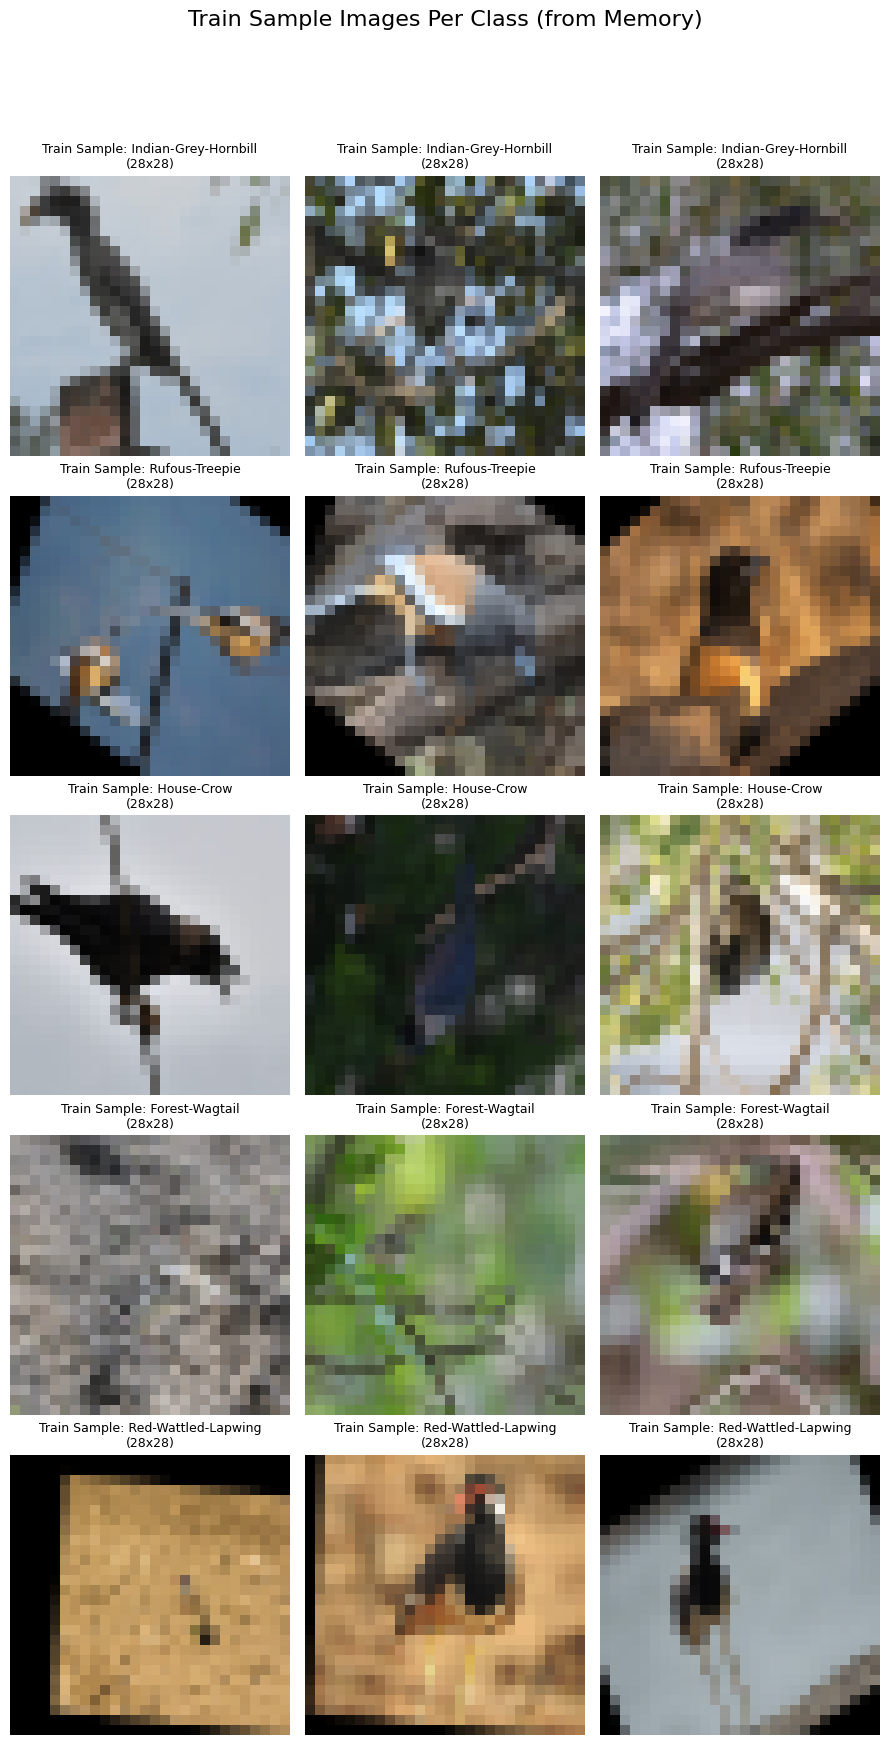


--- Class Distribution Plots (Using Filtered Labels) ---


/tmp/ipykernel_23962/3317433318.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis") #


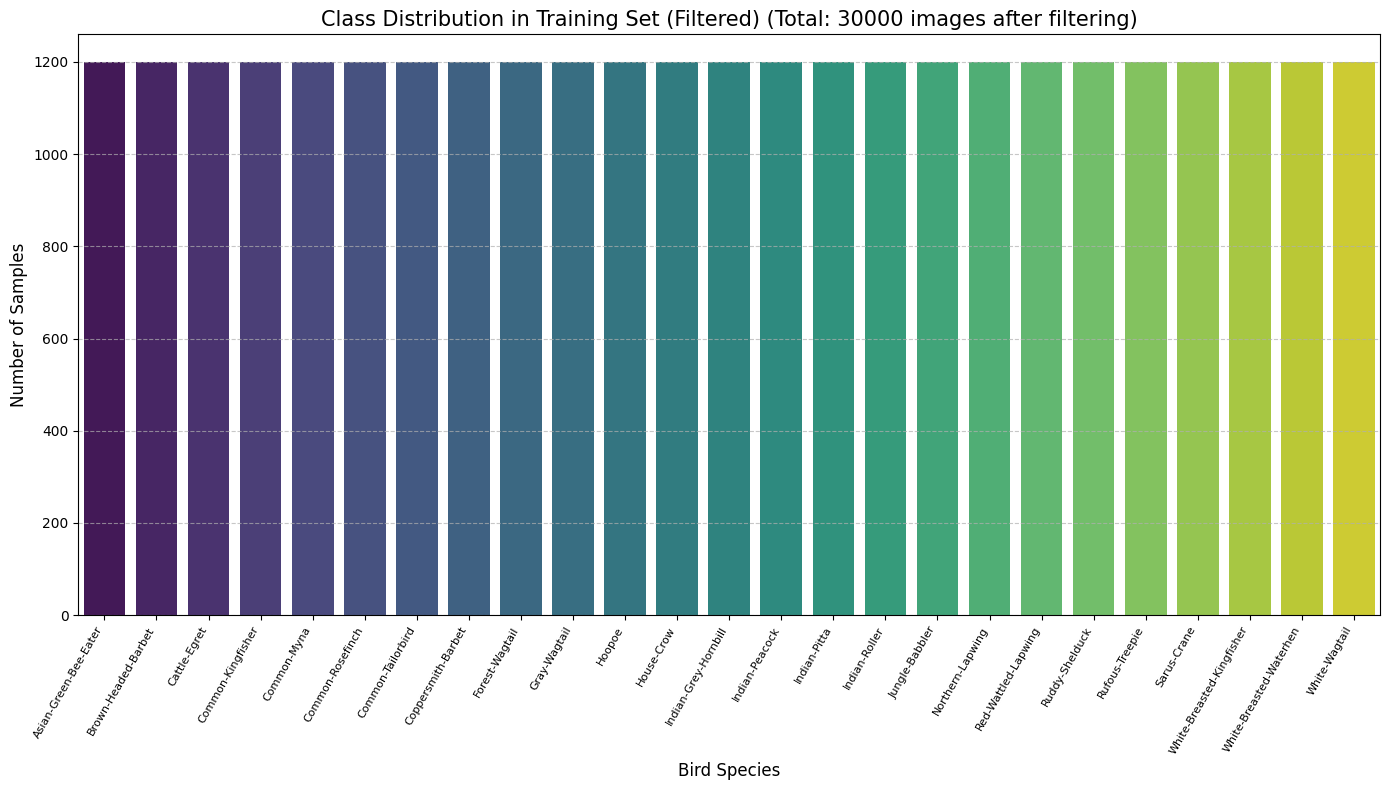

/tmp/ipykernel_23962/3317433318.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis") #


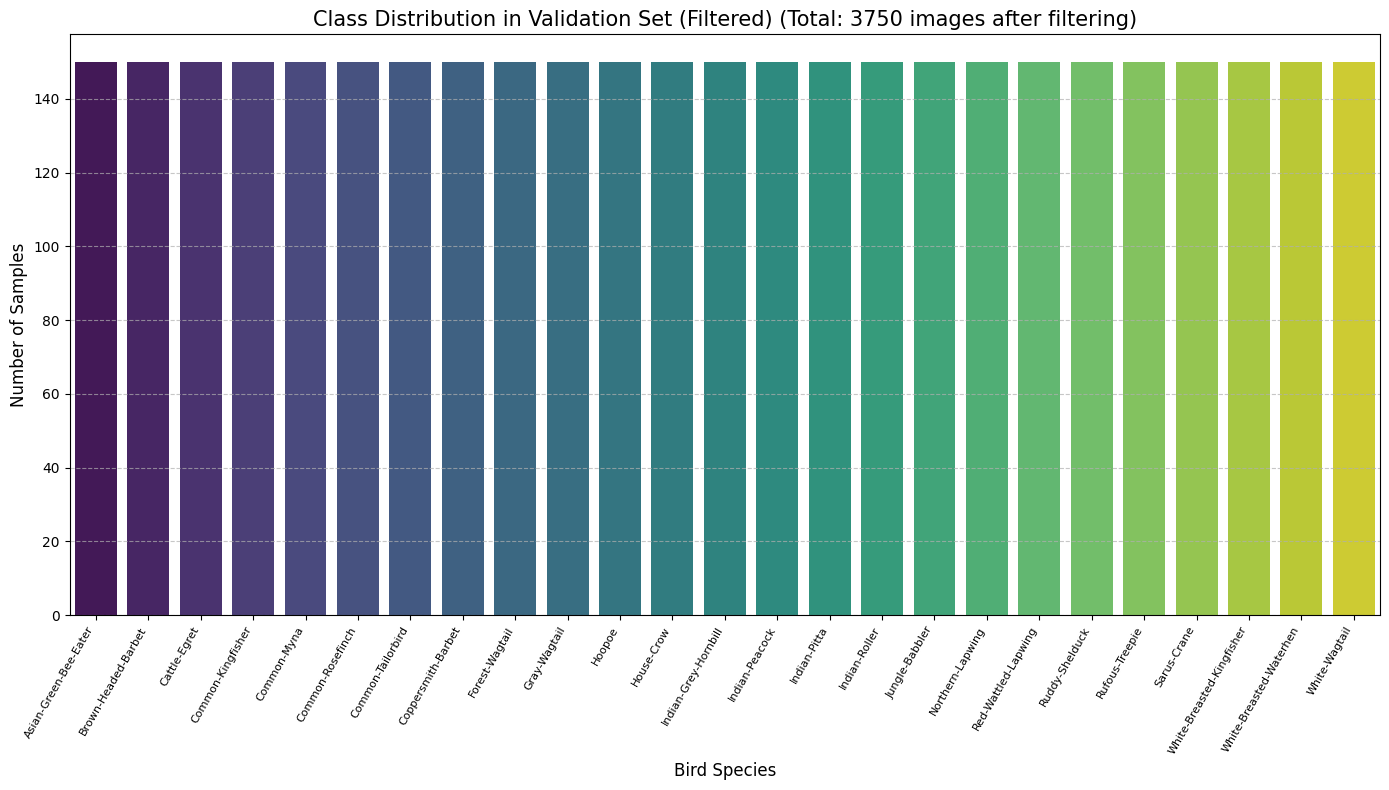

/tmp/ipykernel_23962/3317433318.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis") #


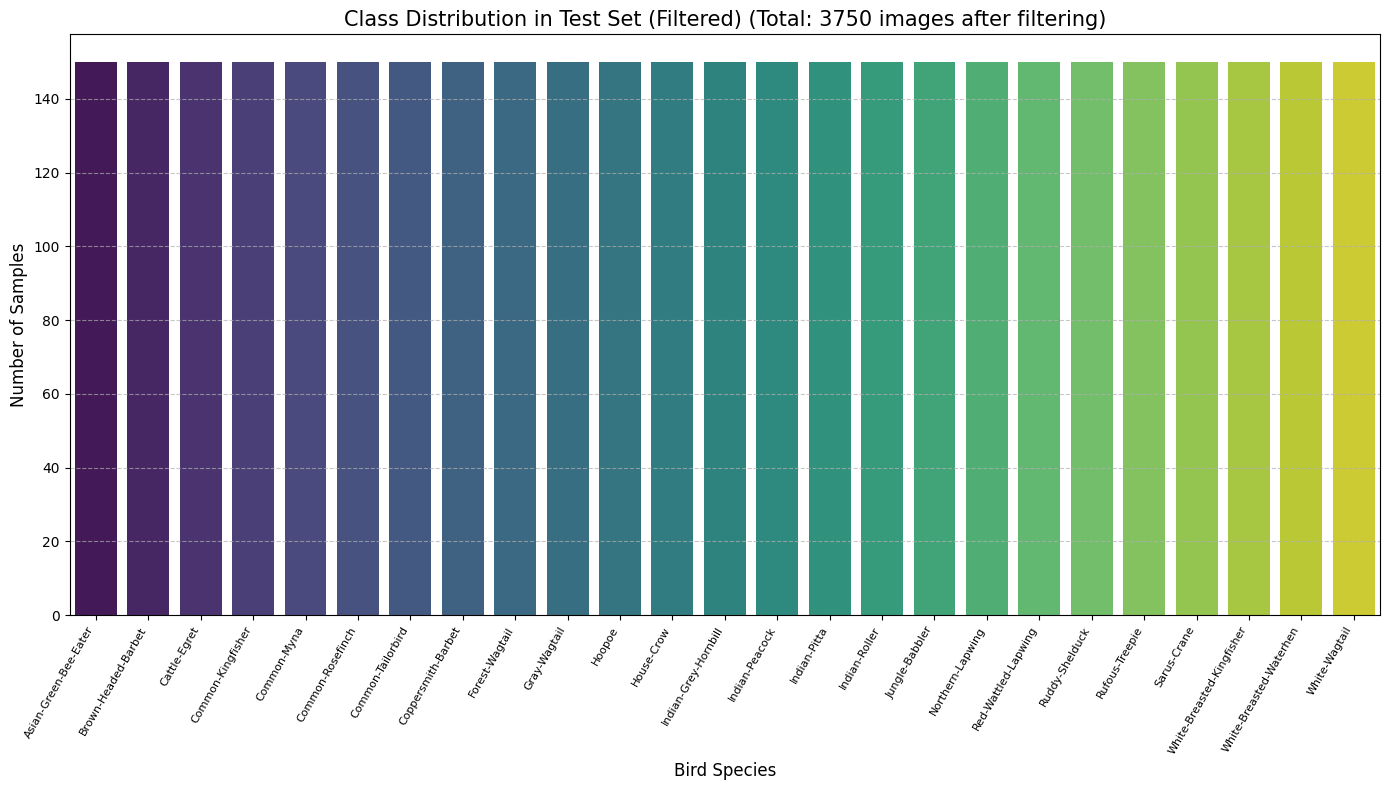


--- Downscaling Effect Visualization (Using a Sample from Memory) ---


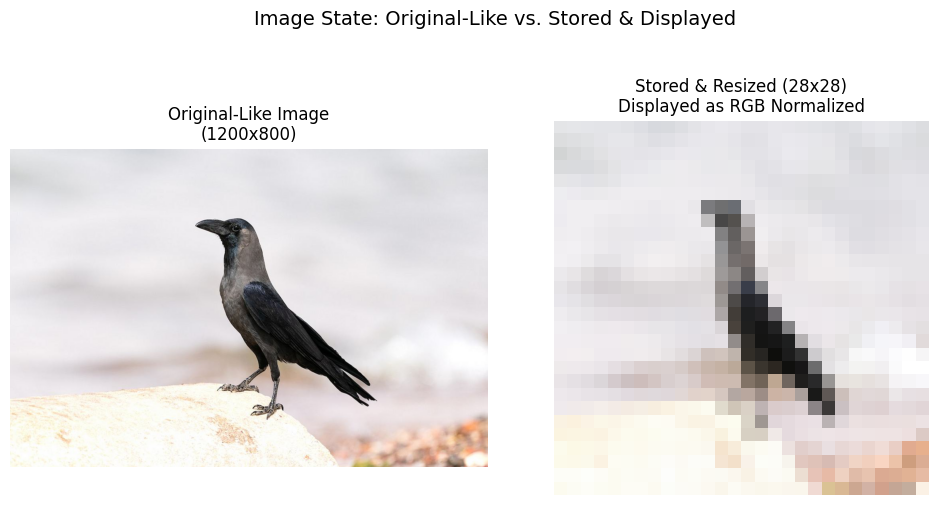


--- Average Images Per Class (from Memory) ---


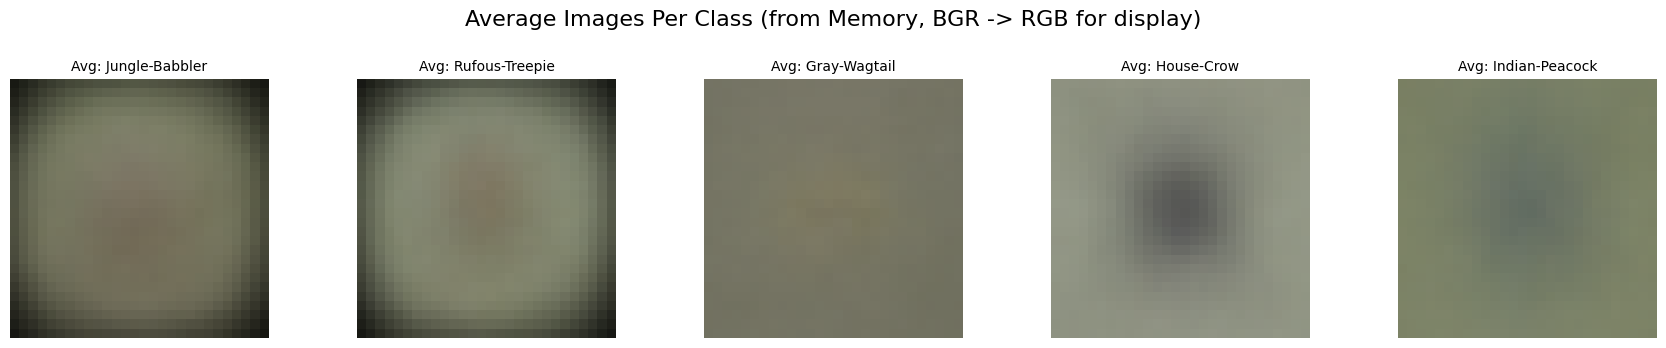


--- Color Histograms for a Sample Image (from Memory, BGR channels) ---


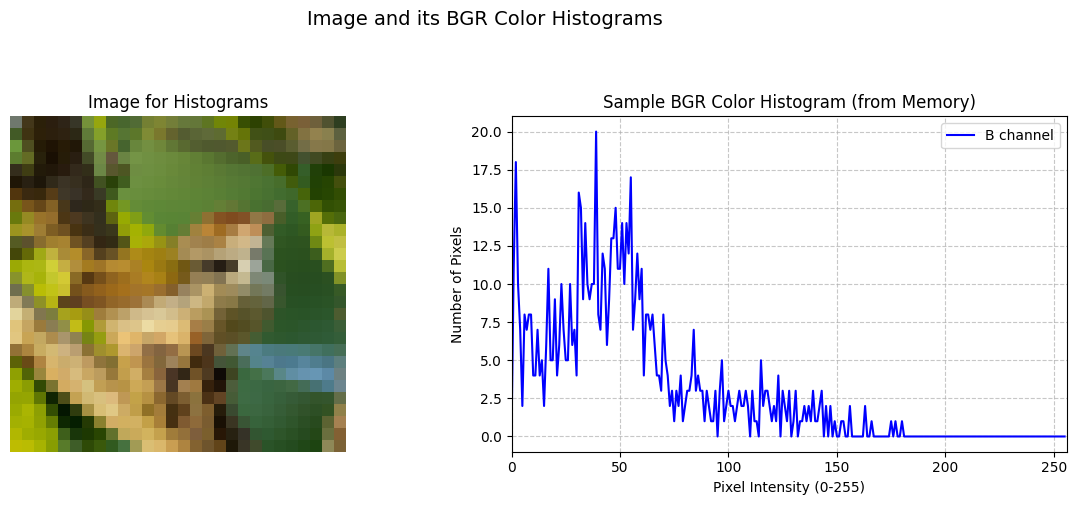


--- t-SNE Visualization of BGR Image Pixel Data (from Memory) ---

Performing t-SNE on a subset of 500 BGR images (from memory)...
t-SNE input shape: (500, 2352), perplexity: 30.0


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_23962/3317433318.py:235: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('turbo', num_unique_labels) if num_unique_labels > 20 else plt.cm.get_cmap('tab20', max(1,num_unique_labels))


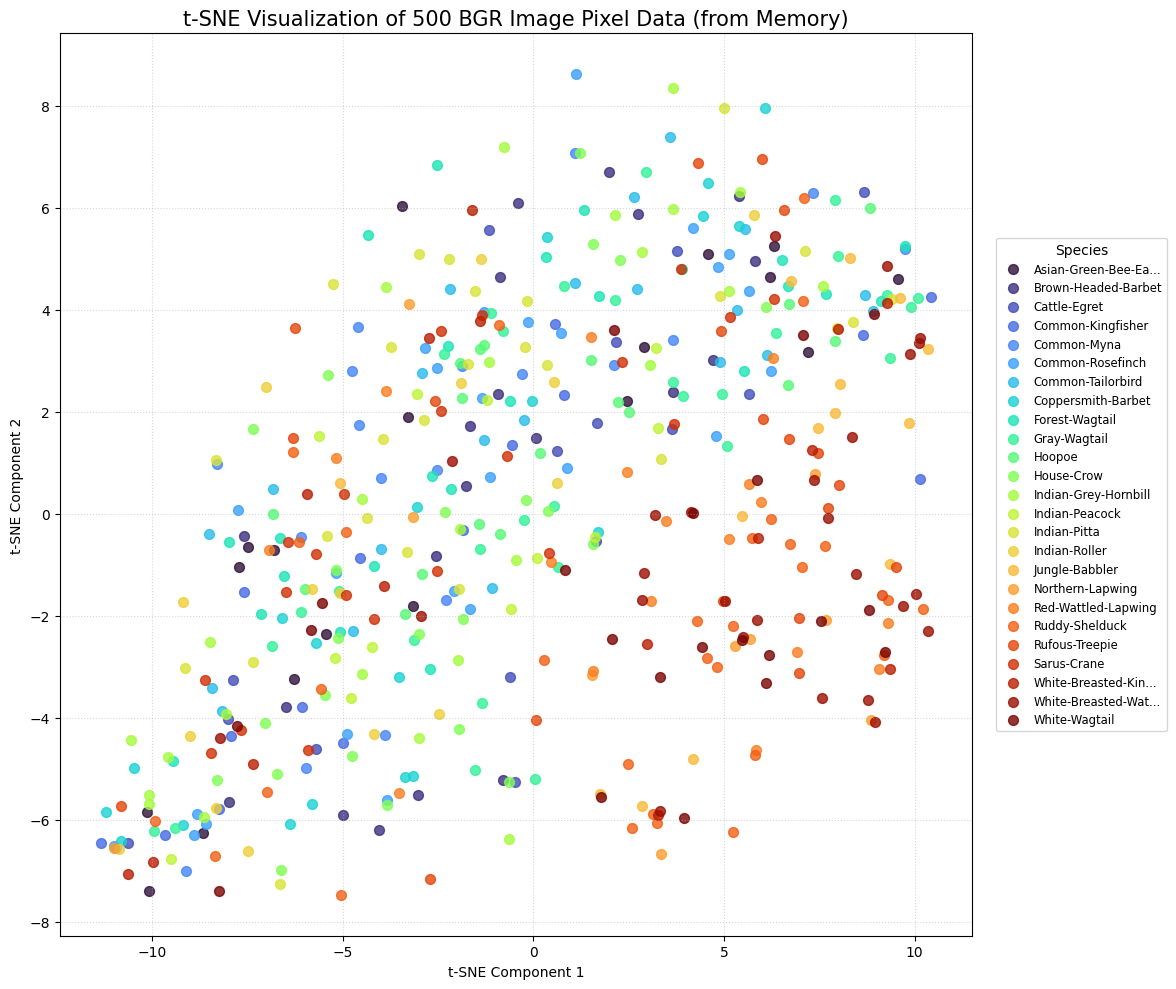

In [7]:

# %% [markdown]
# ## Step 5: Data Visualizations (Using In-Memory Data)
# These calls will now use the pre-loaded and filtered `X_..._images_bgr` and `y_..._final` arrays.

# %% Step 5 Code
# Ensure the variables X_train_images_bgr, y_train_final (and _val, _test versions) 
# and label_mapping are available from the "Efficient Image Loading" cell (Step 3).

print("\n--- Displaying Sample Loaded Images from Training Set (Memory) ---") #
if 'X_train_images_bgr' in globals() and X_train_images_bgr.shape[0] > 0: # Check if array has content
    display_sample_images_from_memory(X_train_images_bgr, y_train_final, label_mapping, num_classes_to_display=5, title_prefix="Train Sample")
else:
    print("X_train_images_bgr is empty or not defined. Cannot display sample images.")

print("\n--- Class Distribution Plots (Using Filtered Labels) ---") #
if 'y_train_final' in globals() and y_train_final.shape[0] > 0:
    plot_class_distribution(y_train_final, label_mapping, "Training Set (Filtered)") #
if 'y_val_final' in globals() and y_val_final.shape[0] > 0:
    plot_class_distribution(y_val_final, label_mapping, "Validation Set (Filtered)") #
if 'y_test_final' in globals() and y_test_final.shape[0] > 0:
    plot_class_distribution(y_test_final, label_mapping, "Test Set (Filtered)") #

print("\n--- Downscaling Effect Visualization (Using a Sample from Memory) ---") #
# We need an original path for this to show the *true* original. We stored successfully_loaded_paths.
if 'X_train_images_bgr' in globals() and X_train_images_bgr.shape[0] > 0 and \
   'X_train_paths_final' in globals() and X_train_paths_final: # Ensure we have paths for original dimensions
    sample_idx_downscale = random.randint(0, X_train_images_bgr.shape[0] - 1)
    img_bgr_resized_for_downscale_demo = X_train_images_bgr[sample_idx_downscale]
    original_path_for_downscale_demo = X_train_paths_final[sample_idx_downscale] # Use the filtered path
    show_downscaling_effect_from_memory_and_path(img_bgr_resized_for_downscale_demo, original_path_for_downscale_demo, IMG_WIDTH, IMG_HEIGHT) #
else:
    print("Cannot show downscaling effect: Training image data or successfully loaded paths are missing.")

print("\n--- Average Images Per Class (from Memory) ---") #
if 'X_train_images_bgr' in globals() and X_train_images_bgr.shape[0] > 0:
    display_average_images_from_memory(X_train_images_bgr, y_train_final, label_mapping, num_classes_to_display=min(NUM_CLASSES if 'NUM_CLASSES' in globals() and NUM_CLASSES > 0 else 5, 5)) #
else:
    print("X_train_images_bgr is empty. Cannot display average images.")

print("\n--- Color Histograms for a Sample Image (from Memory, BGR channels) ---") #
if 'X_train_images_bgr' in globals() and X_train_images_bgr.shape[0] > 0:
    sample_idx_hist = random.randint(0, X_train_images_bgr.shape[0] - 1)
    img_bgr_for_hist_demo = X_train_images_bgr[sample_idx_hist]
    plot_color_histograms_for_bgr_image(img_bgr_for_hist_demo, title="Sample BGR Color Histogram (from Memory)") #
else:
    print("X_train_images_bgr is empty. Cannot display color histograms.")
    
print("\n--- t-SNE Visualization of BGR Image Pixel Data (from Memory) ---") #
# For t-SNE on raw pixels, use the BGR images directly.
# It can be slow, so a subset is recommended as in your original code.
if 'X_train_images_bgr' in globals() and X_train_images_bgr.shape[0] > 0:
    plot_tsne_visualization_from_memory(X_train_images_bgr, y_train_final, label_mapping, n_samples_subset=min(500, X_train_images_bgr.shape[0]), perplexity_val=30.0) # Ensure perplexity is float and less than n_samples
else:
    print("X_train_images_bgr is empty. Cannot run t-SNE visualization.")
    
# %% [markdown]
# --- End of Part 0 (Optimized) ---
# The variables X_train_images_bgr, y_train_final, X_val_images_bgr, y_val_final, 
# X_test_images_bgr, y_test_final, X_train_paths_final (and _val, _test for original path reference)
# and target_names_part1 are now ready for Part 1.

## Part 1: Classification According to Feature Extraction 

### Part 1.1: Library Imports

In [8]:
from skimage.feature import hog # For HoG
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB # Added for a third simple classifier option
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import time
import numpy as np # Should be already imported
import matplotlib.pyplot as plt # Should be already imported
import cv2 # Should be already imported
import random # Should be already imported

### Part 1.2: Visualizing Feature Extraction Algorithms

#### Part 1.2.1: Function Definitions


In [9]:
# %% [markdown]
# # Part 1: Classification According to Feature Extraction (Using In-Memory Images)

# %% [markdown]
# In this part, we will extract features from the pre-loaded and resized BGR images using:
# 1. Color Histogram (HSV)
# 2. Histogram of Oriented Gradients (HoG)
# 3. Gabor Filters
#
# Then, we will apply at least three basic Machine Learning algorithms (Logistic Regression, SVM, Random Forest, and Gaussian Naive Bayes) to classify the bird species based on these extracted features separately.

# %% Setup: Ensure necessary libraries for Part 1 are imported
# (Most should be in your main setup cell from Part 0. These are just reminders for this self-contained Part 1 block)


# Ensure global parameters IMG_WIDTH, IMG_HEIGHT, NUM_CLASSES, and label_mapping
# are defined and that X_train_images_bgr, y_train_final etc. are populated from the "Part 0 (Optimized)" cell.

# %% --- Feature Extraction with Visualization Functions ---
# (These are the extract_hsv_histogram_visualized_en, extract_hog_features_visualized_en,
#  build_gabor_filters, process_with_gabor_filters, extract_gabor_features_visualized_en functions.
#  They operate on single BGR images.)

def extract_hsv_histogram_visualized_en(image_bgr, bins=(8, 8, 8), display_visuals=True):
    if image_bgr is None:
        print("Error: Image_bgr is None in HSV Histogram.")
        return None
    if display_visuals:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
        plt.title("1. Original Image (BGR)")
        plt.axis('off')
    hsv_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
    if display_visuals:
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB))
        plt.title("2. HSV Image")
        plt.axis('off')
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    flat_hist = hist.flatten()
    if display_visuals:
        plt.subplot(1, 3, 3)
        plt.plot(flat_hist)
        plt.title(f"3. Flattened HSV Histogram (Size: {flat_hist.shape[0]})")
        plt.xlabel("Bin Index")
        plt.ylabel("Normalized Value")
        plt.tight_layout()
        plt.show()
    return flat_hist

def extract_hog_features_visualized_en(image_bgr, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, display_visuals=True):
    if image_bgr is None:
        print("Error: Image_bgr is None in HoG.")
        return None
    if display_visuals:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
        plt.title("1. Original Image (BGR)")
        plt.axis('off')
    gray_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    if display_visuals:
        plt.subplot(1, 3, 2)
        plt.imshow(gray_image, cmap='gray')
        plt.title("2. Grayscale Image")
        plt.axis('off')
    # Ensure feature_vector=True if skimage version > 0.19
    try: # For newer skimage versions
        features, hog_image_visualization = hog(gray_image, orientations=orientations, pixels_per_cell=pixels_per_cell, 
                                                cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=True, 
                                                transform_sqrt=True, feature_vector=True)
    except TypeError: # For older skimage versions
        features, hog_image_visualization = hog(gray_image, orientations=orientations, pixels_per_cell=pixels_per_cell, 
                                                cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=True, 
                                                transform_sqrt=True)
    if display_visuals:
        hog_image_rescaled = hog_image_visualization / (hog_image_visualization.max() + 1e-6) # Avoid division by zero
        plt.subplot(1, 3, 3)
        plt.imshow(hog_image_rescaled, cmap='gray')
        plt.title("3. HoG Representation")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(10, 4))
        plt.plot(features)
        plt.title(f"4. HoG Feature Vector (Size: {features.shape[0]})")
        plt.xlabel("Feature Index")
        plt.ylabel("Value")
        plt.tight_layout()
        plt.show()
    return features

def build_gabor_filters(ksize=(31, 31), sigma=5.0, lambd=10.0, gamma=0.5, psi=0):
    g_filters = []
    thetas = np.arange(0, np.pi, np.pi / 4)  # 4 orientations
    lambdas = [lambd, lambd * 2] # 2 frequencies (example parameters)
    for theta_val in thetas:
        for lambda_val in lambdas:
            kern = cv2.getGaborKernel(ksize, sigma, theta_val, lambda_val, gamma, psi, ktype=cv2.CV_32F)
            g_filters.append(kern)
    return g_filters

def process_with_gabor_filters(image_gray, gabor_filters_list):
    gabor_features_list = []
    filtered_imgs_list = []
    for i, kern in enumerate(gabor_filters_list):
        fimg = cv2.filter2D(image_gray, cv2.CV_8UC3, kern) # Apply filter
        gabor_features_list.extend([fimg.mean(), fimg.std()]) # Extract mean and std as features
        if i < 4 and fimg is not None and fimg.size > 0: # Store first 4 valid filtered images
             filtered_imgs_list.append(fimg)
    return np.array(gabor_features_list), filtered_imgs_list
    
def extract_gabor_features_visualized_en(image_bgr, display_visuals=True):
    if image_bgr is None:
        print("Error: Image_bgr is None in Gabor.")
        return None
    
    # Adapt Gabor parameters based on IMG_WIDTH/IMG_HEIGHT if necessary
    # Kernel size should be odd.
    k_size_val = max(5, min(31, int(IMG_WIDTH / 4), int(IMG_HEIGHT / 4))) 
    ksize = (k_size_val if k_size_val % 2 != 0 else k_size_val -1 if k_size_val > 1 else 5, 
             k_size_val if k_size_val % 2 != 0 else k_size_val -1 if k_size_val > 1 else 5)
    if ksize[0] <= 0 : ksize = (5,5) # Fallback ksize
    
    sigma = float(ksize[0]) / 3.0 
    lambd = float(ksize[0]) * 0.8 
    gamma = 0.5      
    psi = 0.0 # Phase offset, typically 0 or pi/2        

    gabor_kernels_bank = build_gabor_filters(ksize=ksize, sigma=sigma, lambd=lambd, gamma=gamma, psi=psi)
    
    if display_visuals:
        fig_main, axes_main = plt.subplots(2, 3, figsize=(12, 7)) # Adjusted for feature plot
        axes_main_flat = axes_main.ravel()

        axes_main_flat[0].imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
        axes_main_flat[0].set_title("1. Original Image (BGR)")
        axes_main_flat[0].axis('off')

    gray_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

    if display_visuals:
        axes_main_flat[1].imshow(gray_image, cmap='gray')
        axes_main_flat[1].set_title("2. Grayscale Image")
        axes_main_flat[1].axis('off')
        
        if len(gabor_kernels_bank) >= 1:
            axes_main_flat[2].imshow(gabor_kernels_bank[0], cmap='gray')
            axes_main_flat[2].set_title(f"Ex. Gabor Kernel 1 ({gabor_kernels_bank[0].shape})")
            axes_main_flat[2].axis('off')
        else:
            axes_main_flat[2].axis('off') # Hide if no kernel

    gabor_feature_vector, example_filtered_images = process_with_gabor_filters(gray_image, gabor_kernels_bank)
    
    if display_visuals:
        if len(example_filtered_images) >= 1:
            axes_main_flat[3].imshow(example_filtered_images[0], cmap='gray')
            axes_main_flat[3].set_title("Ex. Filtered Image 1")
            axes_main_flat[3].axis('off')
        else: axes_main_flat[3].axis('off')
            
        if len(example_filtered_images) >= 2:
            axes_main_flat[4].imshow(example_filtered_images[1], cmap='gray')
            axes_main_flat[4].set_title("Ex. Filtered Image 2")
            axes_main_flat[4].axis('off')
        else: axes_main_flat[4].axis('off')
        
        # Plot the final Gabor feature vector in the last subplot
        axes_main_flat[5].plot(gabor_feature_vector)
        axes_main_flat[5].set_title(f"Gabor Feature Vector (Size: {gabor_feature_vector.shape[0]})")
        axes_main_flat[5].set_xlabel("Feature Index")
        axes_main_flat[5].set_ylabel("Value")
        
        fig_main.suptitle("Gabor Filter Application Steps", fontsize=14, y=1.0) # Add suptitle
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show() 
    return gabor_feature_vector


#### 1.2.2: Feature Extraction Algorithm Graphs

--- Visualizing Feature Extraction for a Sample In-Memory Image ---
Visualizing for a sample from training set, class: Common-Myna

--- HSV Histogram Visualization ---


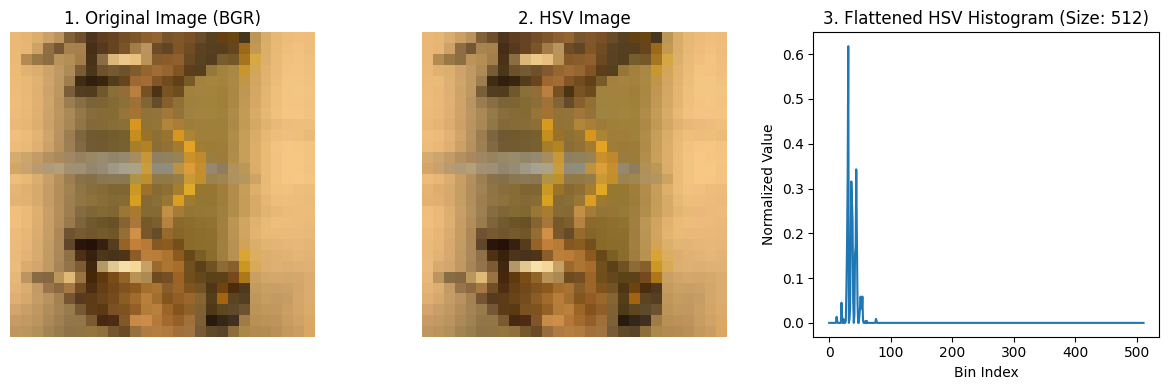


--- HoG Features Visualization ---


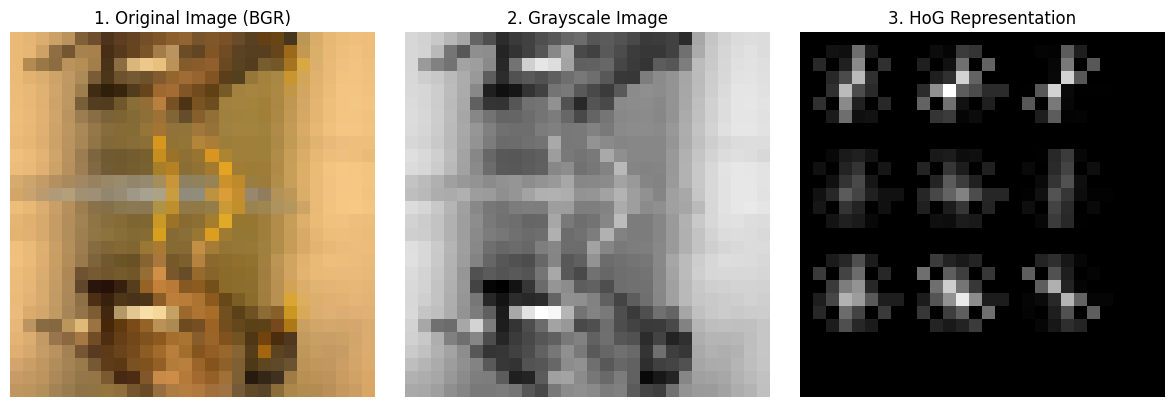

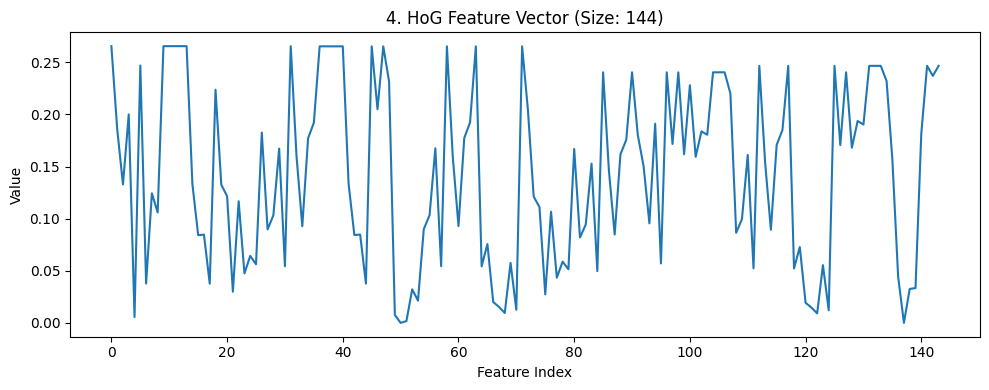


--- Gabor Filter Features Visualization ---


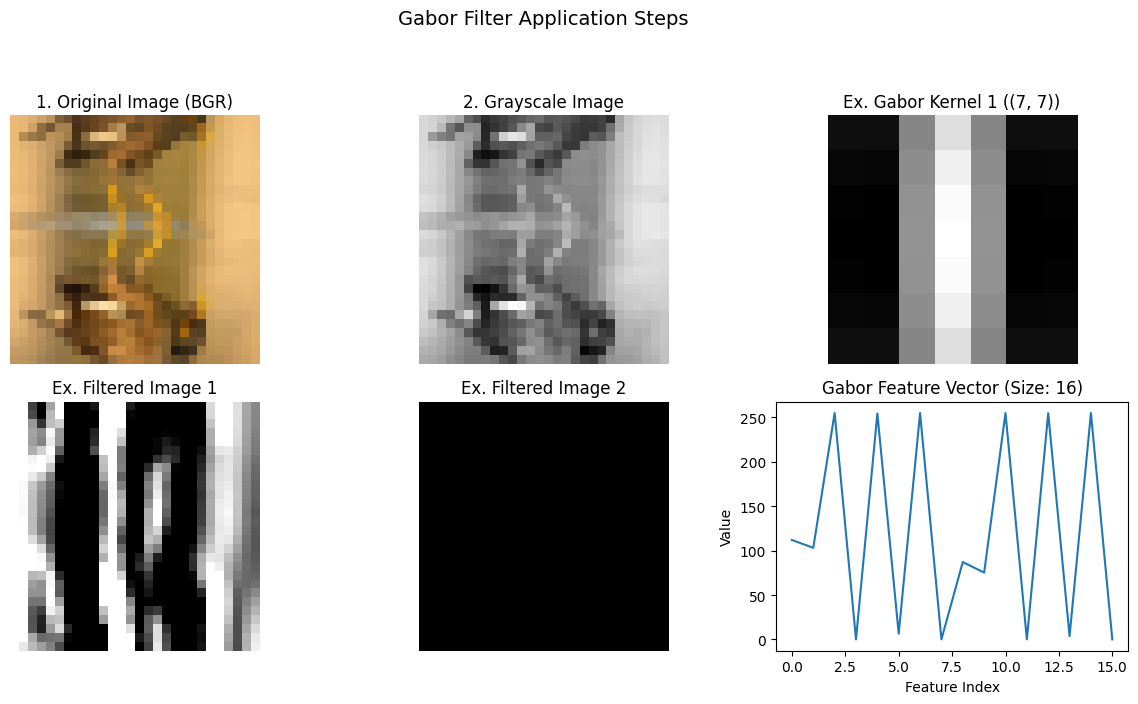

In [10]:

# %% --- Part 1: Feature Extraction Visualization Example (Using In-Memory Images) ---
print("--- Visualizing Feature Extraction for a Sample In-Memory Image ---")

# Assuming X_train_images_bgr, y_train_final, and label_mapping are defined from Part 0 Update
if 'X_train_images_bgr' in globals() and X_train_images_bgr.shape[0] > 0:
    sample_idx_viz = random.randint(0, X_train_images_bgr.shape[0] - 1)
    img_bgr_for_viz = X_train_images_bgr[sample_idx_viz]
    label_for_viz = y_train_final[sample_idx_viz]
    class_name_for_viz = label_mapping.get(label_for_viz, f"Label {label_for_viz}") if 'label_mapping' in globals() else f"Label {label_for_viz}"
    print(f"Visualizing for a sample from training set, class: {class_name_for_viz}")

    print("\n--- HSV Histogram Visualization ---")
    _ = extract_hsv_histogram_visualized_en(img_bgr_for_viz.copy(), display_visuals=True)
    
    print("\n--- HoG Features Visualization ---")
    # Adjust HoG parameters if your IMG_WIDTH/IMG_HEIGHT is large, e.g., pixels_per_cell=(16,16)
    _ = extract_hog_features_visualized_en(img_bgr_for_viz.copy(), pixels_per_cell=(8,8), cells_per_block=(2,2), display_visuals=True) 
    
    print("\n--- Gabor Filter Features Visualization ---")
    _ = extract_gabor_features_visualized_en(img_bgr_for_viz.copy(), display_visuals=True)
else:
    print("X_train_images_bgr is empty or not defined. Cannot run visualization example. Ensure Part 0 Update cell was executed successfully.")



### Part 1.3: Testing Feature Extraction Algorithms with Different Models 

In [11]:

# %% --- Part 1: Function to Extract All Features from Pre-loaded Image Arrays ---
def extract_all_features_from_images_mem(image_array_bgr, feature_extractor_func, **kwargs):
    """
    Extracts features using the provided extractor function from an array of BGR images already in memory.
    The feature_extractor_func should accept a BGR image and display_visuals=False.
    """
    features_list = []
    # Check if image_array_bgr is a NumPy array and has data
    if not isinstance(image_array_bgr, np.ndarray) or image_array_bgr.size == 0: 
        print(f"Warning: Input image_array_bgr for {feature_extractor_func.__name__} is not a valid NumPy array or is empty. Shape: {getattr(image_array_bgr, 'shape', 'N/A')}. Returning empty feature list.")
        # Try to determine expected feature dimension if possible to return a correctly shaped empty array
        # This part is tricky if the array is truly empty/None from the start.
        # For now, returning an empty 1D array.
        return np.array([])
        
    total_images = image_array_bgr.shape[0]
    print(f"Starting feature extraction with {feature_extractor_func.__name__} for {total_images} images from memory...")
    
    # Determine feature dimension from the first image if list will be non-empty
    # to correctly shape an empty array if all extractions fail later.
    expected_feature_dim = -1
    if total_images > 0:
        temp_feat_for_dim = feature_extractor_func(image_array_bgr[0].copy(), display_visuals=False, **kwargs)
        if temp_feat_for_dim is not None:
            expected_feature_dim = temp_feat_for_dim.shape[0]
        else:
            print(f"Warning: Could not determine feature dimension for {feature_extractor_func.__name__} from the first image.")

    for i in range(total_images):
        img_bgr = image_array_bgr[i] 
        
        features = feature_extractor_func(img_bgr.copy(), display_visuals=False, **kwargs) 
        if features is not None:
            features_list.append(features)
        else:
            print(f"Warning: Feature extraction returned None for image at index {i} using {feature_extractor_func.__name__}. This image's features will be missing.")

        if (i + 1) % 250 == 0 or (i + 1) == total_images: 
            print(f"  Processed {i+1}/{total_images} images.")
            
    num_successfully_extracted = len(features_list)
    print(f"Finished extraction with {feature_extractor_func.__name__}. Successfully extracted features for {num_successfully_extracted} out of {total_images} images.")
    
    if num_successfully_extracted == 0 and total_images > 0:
        print(f"CRITICAL WARNING: No features were extracted from {total_images} images using {feature_extractor_func.__name__}.")
        if expected_feature_dim > 0:
            return np.empty((0, expected_feature_dim)) # Return empty array with correct number of columns
        return np.array([]) # Fallback: truly empty array
    
    # If some features were extracted, convert to NumPy array
    # Handle potential inconsistencies in feature vector lengths if any extractor is faulty
    try:
        return np.array(features_list)
    except ValueError as e:
        print(f"Error converting features list to NumPy array for {feature_extractor_func.__name__}: {e}")
        print("This might be due to inconsistent feature vector lengths from the extractor.")
        # Return a partially processed list or an empty array
        return np.array([])


# %% --- Part 1: Extracting All Features for Train, Validation, and Test Sets (Optimized) ---

# These variables (X_train_images_bgr etc.) should be populated by the "Part 0 Update" cell
# HSV Features
print("\nExtracting HSV features from in-memory images...")
X_train_hsv = extract_all_features_from_images_mem(X_train_images_bgr, extract_hsv_histogram_visualized_en, bins=(8,8,8))
X_val_hsv = extract_all_features_from_images_mem(X_val_images_bgr, extract_hsv_histogram_visualized_en, bins=(8,8,8))
X_test_hsv = extract_all_features_from_images_mem(X_test_images_bgr, extract_hsv_histogram_visualized_en, bins=(8,8,8))

# HoG Features
print("\nExtracting HoG features from in-memory images...")
X_train_hog = extract_all_features_from_images_mem(X_train_images_bgr, extract_hog_features_visualized_en, pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9)
X_val_hog = extract_all_features_from_images_mem(X_val_images_bgr, extract_hog_features_visualized_en, pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9)
X_test_hog = extract_all_features_from_images_mem(X_test_images_bgr, extract_hog_features_visualized_en, pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9)

# Gabor Features
print("\nExtracting Gabor features from in-memory images...")
X_train_gabor = extract_all_features_from_images_mem(X_train_images_bgr, extract_gabor_features_visualized_en)
X_val_gabor = extract_all_features_from_images_mem(X_val_images_bgr, extract_gabor_features_visualized_en)
X_test_gabor = extract_all_features_from_images_mem(X_test_images_bgr, extract_gabor_features_visualized_en)


print("\n--- Feature Extraction Shapes (Optimized) ---")
# These feature array shapes should now exactly match the filtered label array shapes 
# (y_train_final, y_val_final, y_test_final) from Part 0 Update,
# UNLESS extract_all_features_from_images_mem skipped some due to internal feature extractor errors.

def print_shape_if_valid(arr, arr_name, y_arr_name, y_arr):
    # Check if arr is a NumPy array and not empty, and y_arr is also valid and not empty
    if isinstance(arr, np.ndarray) and arr.size > 0 and \
       isinstance(y_arr, np.ndarray) and y_arr.size > 0:
        print(f"{arr_name} shape: {arr.shape}, {y_arr_name} shape: {y_arr.shape}")
        if arr.shape[0] != y_arr.shape[0]:
            print(f"    WARNING: Mismatch between {arr_name} ({arr.shape[0]}) and {y_arr_name} ({y_arr.shape[0]}) samples!")
    else:
        print(f"{arr_name} is empty, or its corresponding y_arr ('{y_arr_name}') is missing/empty.")
        if isinstance(arr, np.ndarray): print(f"    {arr_name} shape: {arr.shape}")
        if isinstance(y_arr, np.ndarray): print(f"    {y_arr_name} shape: {y_arr.shape}")


print_shape_if_valid(X_train_hsv, "X_train_hsv", "y_train_final", y_train_final)
print_shape_if_valid(X_val_hsv, "X_val_hsv", "y_val_final", y_val_final)
print_shape_if_valid(X_test_hsv, "X_test_hsv", "y_test_final", y_test_final)

print_shape_if_valid(X_train_hog, "X_train_hog", "y_train_final", y_train_final)
print_shape_if_valid(X_val_hog, "X_val_hog", "y_val_final", y_val_final)
print_shape_if_valid(X_test_hog, "X_test_hog", "y_test_final", y_test_final)

print_shape_if_valid(X_train_gabor, "X_train_gabor", "y_train_final", y_train_final)
print_shape_if_valid(X_val_gabor, "X_val_gabor", "y_val_final", y_val_final)
print_shape_if_valid(X_test_gabor, "X_test_gabor", "y_test_final", y_test_final)


# %% --- Part 1: Training and Evaluating ML Models (Using Pre-loaded Images and Globally Filtered Labels) ---

# Store features in dictionaries (these now directly correspond to the filtered y_train_final, y_val_final, y_test_final)
feature_data_train_mem = {
    "HSV": X_train_hsv,
    "HoG": X_train_hog,
    "Gabor": X_train_gabor
}
feature_data_val_mem = {
    "HSV": X_val_hsv,
    "HoG": X_val_hog,
    "Gabor": X_val_gabor
}
feature_data_test_mem = {
    "HSV": X_test_hsv,
    "HoG": X_test_hog,
    "Gabor": X_test_gabor
}

# Define ML models to try (ensure ml_models is defined, or define it here if running this cell independently)
if 'ml_models' not in globals():
    ml_models = {
        "Logistic Regression": LogisticRegression(max_iter=2000, solver='saga', multi_class='multinomial', C=0.1, random_state=42, n_jobs=-1),
        "SVM (Linear Kernel)": SVC(kernel='linear', C=0.1, probability=True, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1),
        "Gaussian Naive Bayes": GaussianNB()
    }

# Ensure target_names_part1 is defined from Part 0 Update using label_mapping
# This was already handled more robustly at the end of the "Part 0 Update" cell.
# 'target_names_part1' should be available. If not, the fallback there would have printed a warning.
if 'target_names_part1' not in globals() or target_names_part1 is None:
    if 'y_train_final' in globals() and y_train_final.size > 0:
        unique_labels_runtime = np.unique(y_train_final)
        target_names_part1 = [str(i) for i in unique_labels_runtime]
        print(f"Fallback: Using unique labels from y_train_final for target names ({len(unique_labels_runtime)} classes).")
    else: # Absolute fallback
        target_names_part1 = [] # Empty list if no labels
        print("CRITICAL Warning: target_names_part1 cannot be determined. Classification reports will be affected.")


results_part1_optimized = [] 

for feature_name, X_train_feat_opt in feature_data_train_mem.items():
    X_val_feat_opt = feature_data_val_mem.get(feature_name)
    X_test_feat_opt = feature_data_test_mem.get(feature_name)

    # Use the globally filtered y_train_final, y_val_final, y_test_final from "Part 0 Update"
    current_y_train = y_train_final
    current_y_val = y_val_final
    current_y_test = y_test_final
    
    # Check if feature extraction was successful and labels exist FOR THIS SPLIT
    # The number of rows in X_train_feat_opt should now match current_y_train.shape[0] if all images from X_train_images_bgr yielded features
    if not isinstance(X_train_feat_opt, np.ndarray) or X_train_feat_opt.size == 0 or \
       not isinstance(current_y_train, np.ndarray) or current_y_train.size == 0 or \
       X_train_feat_opt.shape[0] != current_y_train.shape[0]:
        print(f"\nSkipping {feature_name} for training: X_train_feat_opt is empty or labels are missing/mismatched "
              f"(Train X:{X_train_feat_opt.shape if isinstance(X_train_feat_opt, np.ndarray) else 'None/Not Array'}, y:{current_y_train.shape if isinstance(current_y_train, np.ndarray) else 'None/Not Array'}).")
        continue
        
    # Determine if validation and test evaluations can run
    run_validation = isinstance(X_val_feat_opt, np.ndarray) and X_val_feat_opt.size > 0 and \
                     isinstance(current_y_val, np.ndarray) and current_y_val.size > 0 and \
                     X_val_feat_opt.shape[0] == current_y_val.shape[0]
    if not run_validation and isinstance(X_val_feat_opt, np.ndarray) and X_val_feat_opt.size > 0 : 
         print(f"\nWarning for {feature_name} validation: Label mismatch or empty labels for validation set (Val X:{X_val_feat_opt.shape}, y:{current_y_val.shape}). Validation eval will be skipped.")
    
    run_test = isinstance(X_test_feat_opt, np.ndarray) and X_test_feat_opt.size > 0 and \
               isinstance(current_y_test, np.ndarray) and current_y_test.size > 0 and \
               X_test_feat_opt.shape[0] == current_y_test.shape[0]
    if not run_test and isinstance(X_test_feat_opt, np.ndarray) and X_test_feat_opt.size > 0:
        print(f"\nWarning for {feature_name} test: Label mismatch or empty labels for test set (Test X:{X_test_feat_opt.shape}, y:{current_y_test.shape}). Test eval will be skipped.")

    print(f"\n===== Evaluating ML Models with {feature_name} Features (Optimized Loading) =====")
    print(f"Using Train X shape: {X_train_feat_opt.shape}, y shape: {current_y_train.shape}")
    if run_validation: print(f"Using Val X shape: {X_val_feat_opt.shape}, y shape: {current_y_val.shape}")
    if run_test: print(f"Using Test X shape: {X_test_feat_opt.shape}, y shape: {current_y_test.shape}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_feat_opt)
    X_val_scaled = scaler.transform(X_val_feat_opt) if run_validation else np.array([]) # Empty if not running
    X_test_scaled = scaler.transform(X_test_feat_opt) if run_test else np.array([])   # Empty if not running
    
    # For classification_report, use labels present in the specific split being evaluated
    # to avoid issues if some classes are not present in val/test after filtering.
    # Also, ensure target_names_part1 is not None
    
    for model_name, model_instance_orig in ml_models.items():
        print(f"\n--- Training {model_name} with {feature_name} ---")
        start_time = time.time()
        
        # Create a new instance of the model using its parameters to ensure it's fresh
        current_model = type(model_instance_orig)(**model_instance_orig.get_params())
        # Re-apply random_state if it exists, to ensure consistent re-runs for models that use it
        if 'random_state' in current_model.get_params() and current_model.get_params()['random_state'] is not None:
            current_model.set_params(random_state=42) # or model_instance_orig.random_state
        if hasattr(current_model, 'n_jobs') and model_name != "Gaussian Naive Bayes": # GaussianNB doesn't have n_jobs
             current_model.set_params(n_jobs=-1)


        try:
            current_model.fit(X_train_scaled, current_y_train)
            train_time = time.time() - start_time

            val_accuracy = 0.0
            val_report_dict = {'macro avg': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}, 'accuracy': 0.0}
            if run_validation and X_val_scaled.size > 0 :
                y_val_pred = current_model.predict(X_val_scaled)
                val_accuracy = accuracy_score(current_y_val, y_val_pred)
                unique_labels_val_eval = np.unique(np.concatenate((current_y_val, y_val_pred)))
                # Use label_encoder.classes_ for target_names if label_mapping was problematic
                tn_val = [label_mapping.get(l, str(l)) for l in unique_labels_val_eval] if 'label_mapping' in globals() and label_mapping else [str(l) for l in unique_labels_val_eval]

                val_report_dict = classification_report(current_y_val, y_val_pred, target_names=tn_val, labels=unique_labels_val_eval, output_dict=True, zero_division=0)
                print(f"Validation Accuracy: {val_accuracy:.4f}")
            else:
                print(f"Validation evaluation skipped for {model_name} with {feature_name}.")


            test_accuracy = 0.0
            test_report_str = "N/A (Test evaluation skipped)"
            test_report_dict = {'macro avg': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}, 'accuracy': 0.0}
            test_time_val = 0.0

            if run_test and X_test_scaled.size > 0:
                start_test_time = time.time()
                y_test_pred = current_model.predict(X_test_scaled)
                test_time_val = time.time() - start_test_time
                
                test_accuracy = accuracy_score(current_y_test, y_test_pred)
                unique_labels_test_eval = np.unique(np.concatenate((current_y_test, y_test_pred)))
                tn_test = [label_mapping.get(l, str(l)) for l in unique_labels_test_eval] if 'label_mapping' in globals() and label_mapping else [str(l) for l in unique_labels_test_eval]
                
                test_report_str = classification_report(current_y_test, y_test_pred, target_names=tn_test, labels=unique_labels_test_eval, zero_division=0)
                test_report_dict = classification_report(current_y_test, y_test_pred, target_names=tn_test, labels=unique_labels_test_eval, output_dict=True, zero_division=0)
                print(f"Test Accuracy: {test_accuracy:.4f}")
                print("Test Set Classification Report:")
                print(test_report_str)
            else:
                 print(f"Test evaluation skipped for {model_name} with {feature_name}.")
            
            results_part1_optimized.append({
                "Feature Set": feature_name,
                "ML Model": model_name,
                "Validation Accuracy": round(val_accuracy, 4),
                "Test Accuracy": round(test_accuracy, 4),
                "Test Precision (macro)": round(test_report_dict['macro avg']['precision'], 4),
                "Test Recall (macro)": round(test_report_dict['macro avg']['recall'], 4),
                "Test F1-Score (macro)": round(test_report_dict['macro avg']['f1-score'], 4),
                "Training Time (s)": round(train_time, 2),
                "Test Time (s)": round(test_time_val, 2)
            })
        except ValueError as ve: 
             print(f"ValueError during {model_name} with {feature_name}: {ve}. This might indicate an issue with feature/label alignment or empty arrays passed to model.")
        except Exception as e:
            print(f"General error training/evaluating {model_name} with {feature_name}: {e}")

# %% --- Part 1: Displaying Optimized Results ---
print("\n\n--- Summary of Part 1 Results (Optimized Loading & Corrected Labels) ---")
df_results_part1_optimized = pd.DataFrame(results_part1_optimized)
if not df_results_part1_optimized.empty:
    df_results_part1_sorted_optimized = df_results_part1_optimized.sort_values(by="Test Accuracy", ascending=False)
    print(df_results_part1_sorted_optimized.to_string())
else:
    print("No results to display for Part 1 (Optimized). Check for errors during feature extraction or model training.")

# %% [markdown]
# ## Part 1: Comments and Interpretations
#
# *(This is where you will write your analysis based on the results obtained above. Consider the performance of different feature extractors with different ML models, training times, and any challenges faced. Also comment on the impact of the efficiency improvements.)*


Extracting HSV features from in-memory images...
Starting feature extraction with extract_hsv_histogram_visualized_en for 30000 images from memory...
  Processed 250/30000 images.
  Processed 500/30000 images.
  Processed 750/30000 images.
  Processed 1000/30000 images.
  Processed 1250/30000 images.
  Processed 1500/30000 images.
  Processed 1750/30000 images.
  Processed 2000/30000 images.
  Processed 2250/30000 images.
  Processed 2500/30000 images.
  Processed 2750/30000 images.
  Processed 3000/30000 images.
  Processed 3250/30000 images.
  Processed 3500/30000 images.
  Processed 3750/30000 images.
  Processed 4000/30000 images.
  Processed 4250/30000 images.
  Processed 4500/30000 images.
  Processed 4750/30000 images.
  Processed 5000/30000 images.
  Processed 5250/30000 images.
  Processed 5500/30000 images.
  Processed 5750/30000 images.
  Processed 6000/30000 images.
  Processed 6250/30000 images.
  Processed 6500/30000 images.
  Processed 6750/30000 images.
  Processed 700

/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy: 0.3144
Test Accuracy: 0.3107
Test Set Classification Report:
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.20      0.23      0.21       150
      Brown-Headed-Barbet       0.30      0.27      0.29       150
             Cattle-Egret       0.27      0.41      0.33       150
        Common-Kingfisher       0.45      0.33      0.38       150
              Common-Myna       0.28      0.23      0.25       150
         Common-Rosefinch       0.27      0.20      0.23       150
        Common-Tailorbird       0.32      0.27      0.29       150
       Coppersmith-Barbet       0.26      0.25      0.25       150
           Forest-Wagtail       0.30      0.35      0.32       150
             Gray-Wagtail       0.17      0.13      0.15       150
                   Hoopoe       0.19      0.27      0.22       150
               House-Crow       0.31      0.27      0.29       150
     Indian-Grey-Hornbill       0.26      0.23

/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy: 0.1752
Test Accuracy: 0.1864
Test Set Classification Report:
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.22      0.22      0.22       150
      Brown-Headed-Barbet       0.14      0.12      0.13       150
             Cattle-Egret       0.16      0.12      0.14       150
        Common-Kingfisher       0.21      0.17      0.19       150
              Common-Myna       0.15      0.13      0.14       150
         Common-Rosefinch       0.10      0.07      0.08       150
        Common-Tailorbird       0.14      0.11      0.12       150
       Coppersmith-Barbet       0.17      0.05      0.08       150
           Forest-Wagtail       0.22      0.43      0.29       150
             Gray-Wagtail       0.16      0.19      0.17       150
                   Hoopoe       0.18      0.25      0.21       150
               House-Crow       0.14      0.11      0.12       150
     Indian-Grey-Hornbill       0.12      0.14

/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy: 0.1877
Test Accuracy: 0.1888
Test Set Classification Report:
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.15      0.13      0.14       150
      Brown-Headed-Barbet       0.16      0.15      0.16       150
             Cattle-Egret       0.19      0.39      0.26       150
        Common-Kingfisher       0.16      0.11      0.13       150
              Common-Myna       0.12      0.06      0.08       150
         Common-Rosefinch       0.12      0.15      0.13       150
        Common-Tailorbird       0.16      0.03      0.05       150
       Coppersmith-Barbet       0.11      0.05      0.07       150
           Forest-Wagtail       0.17      0.25      0.20       150
             Gray-Wagtail       0.17      0.15      0.16       150
                   Hoopoe       0.06      0.03      0.04       150
               House-Crow       0.22      0.37      0.27       150
     Indian-Grey-Hornbill       0.16      0.21

## Part 2: Principal Component Analysis (PCA) and Feature Selection


### Part 2.1: Library Imports and Global Variables

In [12]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

results_part2_pca = []
results_part2_selectkbest = []

### Part 2.2: Applying PCA and Evaluating ML Models

In [13]:
# %% [markdown]
# # Part 2: Principal Component Analysis (PCA) and Feature Selection

# %% [markdown]
# In this part, we will:
# 1. Apply PCA to the features extracted in Part 1 (HSV, HoG, Gabor - from in-memory image processing).
# 2. Apply a feature selection method (SelectKBest with f_classif) to the same features from Part 1.
# 3. Re-run the same ML algorithms used in Part 1 on these new, dimensionally-reduced or selected feature sets.


# %% --- Part 2.1: Applying PCA and Evaluating ML Models ---
print("\n--- Starting Part 2.1: Principal Component Analysis (PCA) ---")

# Use the feature data dictionary name as defined in your updated Part 1
# I'll use 'feature_data_train_mem' as per our discussion on optimizing memory and disk reads.
# If you used 'feature_data_train_opt' in Part 1, change it here accordingly.
PART1_FEATURE_TRAIN_DICT_NAME = 'feature_data_train_mem' if 'feature_data_train_mem' in globals() else 'feature_data_train_opt'
PART1_FEATURE_VAL_DICT_NAME = 'feature_data_val_mem' if 'feature_data_val_mem' in globals() else 'feature_data_val_opt'
PART1_FEATURE_TEST_DICT_NAME = 'feature_data_test_mem' if 'feature_data_test_mem' in globals() else 'feature_data_test_opt'


if PART1_FEATURE_TRAIN_DICT_NAME not in globals() or \
   not isinstance(globals()[PART1_FEATURE_TRAIN_DICT_NAME], dict) or \
   'y_train_final' not in globals() or \
   'ml_models' not in globals():
    print(f"ERROR: Part 1 feature sets (e.g., {PART1_FEATURE_TRAIN_DICT_NAME}), labels (y_train_final), or ml_models are not defined/valid. Please run Part 1 first.")
else:
    # Get the actual dictionary from globals using the determined name
    feature_data_train_source = globals()[PART1_FEATURE_TRAIN_DICT_NAME]
    feature_data_val_source = globals()[PART1_FEATURE_VAL_DICT_NAME]
    feature_data_test_source = globals()[PART1_FEATURE_TEST_DICT_NAME]

    for feature_name, X_train_orig in feature_data_train_source.items():
        X_val_orig = feature_data_val_source.get(feature_name)
        X_test_orig = feature_data_test_source.get(feature_name)

        # Use globally filtered labels from Part 0 Update
        current_y_train = y_train_final
        current_y_val = y_val_final
        current_y_test = y_test_final

        # Validate that feature arrays are not empty and match label counts
        if not isinstance(X_train_orig, np.ndarray) or X_train_orig.size == 0 or \
           (X_train_orig.ndim == 2 and X_train_orig.shape[0] != current_y_train.shape[0]) or \
           (X_train_orig.ndim == 1 and X_train_orig.shape[0] == 0 and current_y_train.shape[0] > 0): # Handle 1D arrays if feature extraction failed for all samples
            print(f"\nSkipping PCA for {feature_name}: Training features are empty or mismatched with labels (X: {X_train_orig.shape if isinstance(X_train_orig, np.ndarray) else 'None'}, y: {current_y_train.shape}).")
            continue
        
        run_validation_pca = isinstance(X_val_orig, np.ndarray) and X_val_orig.size > 0 and \
                             isinstance(current_y_val, np.ndarray) and current_y_val.size > 0 and \
                             X_val_orig.shape[0] == current_y_val.shape[0]
        if not run_validation_pca and isinstance(X_val_orig, np.ndarray) and X_val_orig.size > 0:
            print(f"Warning for PCA on {feature_name} validation: Label mismatch or empty labels. Validation eval will be skipped.")
            
        run_test_pca = isinstance(X_test_orig, np.ndarray) and X_test_orig.size > 0 and \
                       isinstance(current_y_test, np.ndarray) and current_y_test.size > 0 and \
                       X_test_orig.shape[0] == current_y_test.shape[0]
        if not run_test_pca and isinstance(X_test_orig, np.ndarray) and X_test_orig.size > 0:
            print(f"Warning for PCA on {feature_name} test: Label mismatch or empty labels. Test eval will be skipped.")


        print(f"\n===== Applying PCA to {feature_name} Features =====")
        print(f"Original Train X shape: {X_train_orig.shape}, y shape: {current_y_train.shape}")
        if run_validation_pca: print(f"Original Val X shape: {X_val_orig.shape}, y shape: {current_y_val.shape}")
        if run_test_pca: print(f"Original Test X shape: {X_test_orig.shape}, y shape: {current_y_test.shape}")

        # 1. Scale original features before PCA 
        # (These features are unscaled from Part 1's feature_data_train_source)
        scaler_for_pca = StandardScaler()
        X_train_scaled_for_pca = scaler_for_pca.fit_transform(X_train_orig)
        # Ensure validation/test sets are 2D for transform, even if they become empty after feature extraction
        X_val_scaled_for_pca = scaler_for_pca.transform(X_val_orig) if run_validation_pca and X_val_orig.ndim == 2 else np.array([])
        X_test_scaled_for_pca = scaler_for_pca.transform(X_test_orig) if run_test_pca and X_test_orig.ndim == 2 else np.array([])

        # 2. Apply PCA
        n_max_comp_pca = min(X_train_scaled_for_pca.shape[0], X_train_scaled_for_pca.shape[1])
        
        if n_max_comp_pca == 0: 
             print(f"  No data or features to apply PCA for {feature_name} after scaling. Skipping.")
             continue
        elif n_max_comp_pca == 1: 
            pca = PCA(n_components=1, random_state=42)
        else: 
            pca = PCA(n_components=0.95, random_state=42) 
        
        print(f"Fitting PCA on scaled {feature_name} training data (shape: {X_train_scaled_for_pca.shape}). Using n_components target for 95% variance (or {n_max_comp_pca} if less).")
        try:
            X_train_pca = pca.fit_transform(X_train_scaled_for_pca)
            X_val_pca = pca.transform(X_val_scaled_for_pca) if run_validation_pca and X_val_scaled_for_pca.size > 0 else np.array([])
            X_test_pca = pca.transform(X_test_scaled_for_pca) if run_test_pca and X_test_scaled_for_pca.size > 0 else np.array([])
        except ValueError as e_pca: 
            print(f"  PCA Error for {feature_name} with 0.95 variance: {e_pca}. Trying with explicit n_components=min(n_samples, n_features).")
            try:
                explicit_n_comp = min(X_train_scaled_for_pca.shape) 
                if explicit_n_comp == 0: 
                    print(f" PCA Fallback Error: Cannot use 0 components for {feature_name}. Skipping.")
                    continue
                pca_fallback = PCA(n_components=explicit_n_comp, random_state=42)
                X_train_pca = pca_fallback.fit_transform(X_train_scaled_for_pca)
                X_val_pca = pca_fallback.transform(X_val_scaled_for_pca) if run_validation_pca and X_val_scaled_for_pca.size > 0 else np.array([])
                X_test_pca = pca_fallback.transform(X_test_scaled_for_pca) if run_test_pca and X_test_scaled_for_pca.size > 0 else np.array([])
                pca = pca_fallback 
            except Exception as e_pca_fallback:
                print(f"  PCA Fallback Error for {feature_name}: {e_pca_fallback}. Skipping PCA for this feature set.")
                continue
                
        n_components_selected_pca = pca.n_components_
        print(f"PCA selected {n_components_selected_pca} components for {feature_name}.")
        print(f"Shape after PCA - Train: {X_train_pca.shape}, Val: {X_val_pca.shape if X_val_pca.size > 0 else 'N/A'}, Test: {X_test_pca.shape if X_test_pca.size > 0 else 'N/A'}")

        # 3. Data is already scaled before PCA.

        # 4. Evaluate ML models on PCA-transformed features
        for model_name, model_instance_orig in ml_models.items(): # Using ml_models from Part 1
            print(f"\n--- Training {model_name} with PCA-transformed {feature_name} ---")
            start_time = time.time()
            
            current_model_pca = type(model_instance_orig)(**model_instance_orig.get_params())
            if 'random_state' in current_model_pca.get_params(): current_model_pca.set_params(random_state=42)
            if hasattr(current_model_pca, 'n_jobs') and model_name != "Gaussian Naive Bayes": current_model_pca.set_params(n_jobs=-1)
                
            try:
                current_model_pca.fit(X_train_pca, current_y_train)
                train_time = time.time() - start_time

                val_accuracy_pca = 0.0
                val_report_dict_pca_default = {'macro avg': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}, 'accuracy': 0.0}
                if run_validation_pca and X_val_pca.size > 0 :
                    y_val_pred_pca = current_model_pca.predict(X_val_pca)
                    val_accuracy_pca = accuracy_score(current_y_val, y_val_pred_pca)
                    labels_val_eval_pca = np.unique(np.concatenate((current_y_val, y_val_pred_pca)))
                    target_names_val_eval_pca = [label_mapping.get(l, str(l)) for l in labels_val_eval_pca] if 'label_mapping' in globals() and label_mapping else [str(l) for l in labels_val_eval_pca]
                    val_report_dict_pca = classification_report(current_y_val, y_val_pred_pca, target_names=target_names_val_eval_pca, labels=labels_val_eval_pca, output_dict=True, zero_division=0)
                    print(f"Validation Accuracy (PCA): {val_accuracy_pca:.4f}")
                else:
                    val_report_dict_pca = val_report_dict_pca_default
                    if run_validation_pca: print(f"Validation evaluation skipped for PCA {feature_name} with {model_name} (empty X_val_pca).")

                test_accuracy_pca = 0.0
                test_report_str_pca = "N/A (Test evaluation skipped)"
                test_report_dict_pca_default = {'macro avg': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}, 'accuracy': 0.0}
                test_time_pca = 0.0
                if run_test_pca and X_test_pca.size > 0:
                    start_test_time = time.time()
                    y_test_pred_pca = current_model_pca.predict(X_test_pca)
                    test_time_pca = time.time() - start_test_time
                    
                    test_accuracy_pca = accuracy_score(current_y_test, y_test_pred_pca)
                    labels_test_eval_pca = np.unique(np.concatenate((current_y_test, y_test_pred_pca)))
                    target_names_test_eval_pca = [label_mapping.get(l, str(l)) for l in labels_test_eval_pca] if 'label_mapping' in globals() and label_mapping else [str(l) for l in labels_test_eval_pca]

                    test_report_str_pca = classification_report(current_y_test, y_test_pred_pca, target_names=target_names_test_eval_pca, labels=labels_test_eval_pca, zero_division=0)
                    test_report_dict_pca = classification_report(current_y_test, y_test_pred_pca, target_names=target_names_test_eval_pca, labels=labels_test_eval_pca, output_dict=True, zero_division=0)
                    print(f"Test Accuracy (PCA): {test_accuracy_pca:.4f}")
                    print("Test Set Classification Report (PCA):")
                    print(test_report_str_pca)
                else:
                    test_report_dict_pca = test_report_dict_pca_default
                    if run_test_pca: print(f"Test evaluation skipped for PCA {feature_name} with {model_name} (empty X_test_pca).")
                
                results_part2_pca.append({
                    "Feature Set": f"{feature_name}_PCA_{n_components_selected_pca}comp",
                    "ML Model": model_name,
                    "Validation Accuracy": round(val_accuracy_pca, 4),
                    "Test Accuracy": round(test_accuracy_pca, 4),
                    "Test Precision (macro)": round(test_report_dict_pca['macro avg']['precision'], 4),
                    "Test Recall (macro)": round(test_report_dict_pca['macro avg']['recall'], 4),
                    "Test F1-Score (macro)": round(test_report_dict_pca['macro avg']['f1-score'], 4),
                    "Training Time (s)": round(train_time, 2),
                    "Test Time (s)": round(test_time_pca, 2)
                })
            except ValueError as ve_pca_model:
                print(f"ValueError training/evaluating {model_name} with PCA {feature_name}: {ve_pca_model}")
            except Exception as e_pca_model:
                print(f"General error training/evaluating {model_name} with PCA-transformed {feature_name}: {e_pca_model}")



--- Starting Part 2.1: Principal Component Analysis (PCA) ---

===== Applying PCA to HSV Features =====
Original Train X shape: (30000, 512), y shape: (30000,)
Original Val X shape: (3750, 512), y shape: (3750,)
Original Test X shape: (3750, 512), y shape: (3750,)
Fitting PCA on scaled HSV training data (shape: (30000, 512)). Using n_components target for 95% variance (or 512 if less).
PCA selected 352 components for HSV.
Shape after PCA - Train: (30000, 352), Val: (3750, 352), Test: (3750, 352)

--- Training Logistic Regression with PCA-transformed HSV ---


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy (PCA): 0.3101
Test Accuracy (PCA): 0.3120
Test Set Classification Report (PCA):
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.20      0.22      0.21       150
      Brown-Headed-Barbet       0.28      0.27      0.28       150
             Cattle-Egret       0.27      0.43      0.34       150
        Common-Kingfisher       0.49      0.33      0.39       150
              Common-Myna       0.28      0.23      0.25       150
         Common-Rosefinch       0.27      0.17      0.20       150
        Common-Tailorbird       0.30      0.26      0.28       150
       Coppersmith-Barbet       0.27      0.25      0.26       150
           Forest-Wagtail       0.30      0.35      0.32       150
             Gray-Wagtail       0.17      0.14      0.15       150
                   Hoopoe       0.20      0.30      0.24       150
               House-Crow       0.32      0.28      0.30       150
     Indian-Grey-Hornbill   

/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy (PCA): 0.1669
Test Accuracy (PCA): 0.1752
Test Set Classification Report (PCA):
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.19      0.21      0.20       150
      Brown-Headed-Barbet       0.14      0.11      0.12       150
             Cattle-Egret       0.14      0.10      0.12       150
        Common-Kingfisher       0.20      0.15      0.17       150
              Common-Myna       0.13      0.11      0.12       150
         Common-Rosefinch       0.11      0.06      0.08       150
        Common-Tailorbird       0.16      0.11      0.13       150
       Coppersmith-Barbet       0.11      0.03      0.05       150
           Forest-Wagtail       0.19      0.41      0.26       150
             Gray-Wagtail       0.16      0.19      0.17       150
                   Hoopoe       0.16      0.22      0.19       150
               House-Crow       0.15      0.10      0.12       150
     Indian-Grey-Hornbill   

/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy (PCA): 0.1728
Test Accuracy (PCA): 0.1821
Test Set Classification Report (PCA):
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.13      0.11      0.12       150
      Brown-Headed-Barbet       0.14      0.13      0.14       150
             Cattle-Egret       0.14      0.29      0.19       150
        Common-Kingfisher       0.18      0.10      0.13       150
              Common-Myna       0.08      0.01      0.01       150
         Common-Rosefinch       0.12      0.19      0.15       150
        Common-Tailorbird       0.10      0.04      0.06       150
       Coppersmith-Barbet       0.13      0.05      0.08       150
           Forest-Wagtail       0.17      0.29      0.21       150
             Gray-Wagtail       0.15      0.13      0.14       150
                   Hoopoe       0.14      0.07      0.10       150
               House-Crow       0.19      0.33      0.24       150
     Indian-Grey-Hornbill   

### Part 2.3: Applying Feature Selection (SelectKBest) and Evaluating ML Models

In [14]:

# %% --- Part 2.2: Applying Feature Selection (SelectKBest) and Evaluating ML Models ---
print("\n\n--- Starting Part 2.2: Feature Selection (SelectKBest) ---")

if PART1_FEATURE_TRAIN_DICT_NAME not in globals() or \
   not isinstance(globals()[PART1_FEATURE_TRAIN_DICT_NAME], dict) or \
   'y_train_final' not in globals() or \
   'ml_models' not in globals(): #
    print(f"Error: Part 1 feature sets (e.g., {PART1_FEATURE_TRAIN_DICT_NAME}), labels (y_train_final), or ml_models are not defined/valid. Please run Part 1 first.")
else:
    feature_data_train_source_skb = globals()[PART1_FEATURE_TRAIN_DICT_NAME]
    feature_data_val_source_skb = globals()[PART1_FEATURE_VAL_DICT_NAME]
    feature_data_test_source_skb = globals()[PART1_FEATURE_TEST_DICT_NAME]
    
    for feature_name, X_train_orig in feature_data_train_source_skb.items():
        X_val_orig = feature_data_val_source_skb.get(feature_name)
        X_test_orig = feature_data_test_source_skb.get(feature_name)

        current_y_train = y_train_final
        current_y_val = y_val_final
        current_y_test = y_test_final

        if not isinstance(X_train_orig, np.ndarray) or X_train_orig.size == 0 or \
           (X_train_orig.ndim == 2 and X_train_orig.shape[0] != current_y_train.shape[0]) or \
           (X_train_orig.ndim == 1 and X_train_orig.shape[0] == 0 and current_y_train.shape[0] > 0):
            print(f"\nSkipping SelectKBest for {feature_name}: Training features are empty or mismatched with labels.")
            continue

        run_validation_skb = isinstance(X_val_orig, np.ndarray) and X_val_orig.size > 0 and \
                             isinstance(current_y_val, np.ndarray) and current_y_val.size > 0 and \
                             X_val_orig.shape[0] == current_y_val.shape[0]
        if not run_validation_skb and isinstance(X_val_orig, np.ndarray) and X_val_orig.size > 0:
             print(f"Warning for SelectKBest {feature_name} validation: Label mismatch or empty labels. Validation eval will be skipped.")

        run_test_skb = isinstance(X_test_orig, np.ndarray) and X_test_orig.size > 0 and \
                       isinstance(current_y_test, np.ndarray) and current_y_test.size > 0 and \
                       X_test_orig.shape[0] == current_y_test.shape[0]
        if not run_test_skb and isinstance(X_test_orig, np.ndarray) and X_test_orig.size > 0:
            print(f"Warning for SelectKBest {feature_name} test: Label mismatch or empty labels. Test eval will be skipped.")
            
        print(f"\n===== Applying Feature Selection (SelectKBest) to {feature_name} Features =====")
        print(f"Original Train X shape: {X_train_orig.shape}, y shape: {current_y_train.shape}")

        # 1. Scale original features before feature selection
        scaler_for_skb = StandardScaler()
        X_train_scaled_for_skb = scaler_for_skb.fit_transform(X_train_orig)
        X_val_scaled_for_skb = scaler_for_skb.transform(X_val_orig) if run_validation_skb and X_val_orig.ndim == 2 else np.array([])
        X_test_scaled_for_skb = scaler_for_skb.transform(X_test_orig) if run_test_skb and X_test_orig.ndim == 2 else np.array([])
        
        # 2. Apply SelectKBest
        original_num_features_skb = X_train_scaled_for_skb.shape[1]
        
        if original_num_features_skb == 0:
            print(f"No features to select from for {feature_name} after scaling. Skipping SelectKBest.")
            continue

        # Determine k: min(100, 50% of features, or original_num_features if very few)
        if original_num_features_skb <= 10: 
            k_final_select_skb = original_num_features_skb
        else:
            k_half_select_skb = int(original_num_features_skb * 0.5)
            k_final_select_skb = min(100, k_half_select_skb) 
            if k_final_select_skb == 0 and original_num_features_skb > 0 : k_final_select_skb = 1 # Ensure at least 1 feature

        print(f"Selecting top {k_final_select_skb} features from {feature_name} (original scaled: {original_num_features_skb})...")
        
        try:
            selector_skb = SelectKBest(score_func=f_classif, k=k_final_select_skb)
            X_train_selectkbest = selector_skb.fit_transform(X_train_scaled_for_skb, current_y_train)
            X_val_selectkbest = selector_skb.transform(X_val_scaled_for_skb) if run_validation_skb and X_val_scaled_for_skb.size > 0 else np.array([])
            X_test_selectkbest = selector_skb.transform(X_test_scaled_for_skb) if run_test_skb and X_test_scaled_for_skb.size > 0 else np.array([])
        except ValueError as e_skb: 
             print(f"  SelectKBest Error for {feature_name}: {e_skb}. Possibly k > n_features. Trying k=min(k_final_select_skb, n_features).")
             try:
                 k_fallback_skb_val = min(k_final_select_skb, X_train_scaled_for_skb.shape[1])
                 if k_fallback_skb_val == 0 and X_train_scaled_for_skb.shape[1] > 0: k_fallback_skb_val = 1
                 elif k_fallback_skb_val == 0:
                     print(f"  Cannot select 0 features for {feature_name} (original has {X_train_scaled_for_skb.shape[1]}). Skipping SelectKBest.")
                     continue
                 selector_fallback_skb_inst = SelectKBest(score_func=f_classif, k=k_fallback_skb_val)
                 X_train_selectkbest = selector_fallback_skb_inst.fit_transform(X_train_scaled_for_skb, current_y_train)
                 X_val_selectkbest = selector_fallback_skb_inst.transform(X_val_scaled_for_skb) if run_validation_skb and X_val_scaled_for_skb.size > 0 else np.array([])
                 X_test_selectkbest = selector_fallback_skb_inst.transform(X_test_scaled_for_skb) if run_test_skb and X_test_scaled_for_skb.size > 0 else np.array([])
                 k_final_select_skb = k_fallback_skb_val 
             except Exception as e_fallback_skb_inner:
                 print(f"  SelectKBest Fallback Error for {feature_name}: {e_fallback_skb_inner}. Skipping this feature set for SelectKBest.")
                 continue
        
        print(f"Shape after SelectKBest - Train: {X_train_selectkbest.shape}, Val: {X_val_selectkbest.shape if X_val_selectkbest.size > 0 else 'N/A'}, Test: {X_test_selectkbest.shape if X_test_selectkbest.size > 0 else 'N/A'}")

        # 3. Data was already scaled before selection.

        # 4. Evaluate ML models on selected features
        for model_name, model_instance_orig in ml_models.items(): # Using ml_models from Part 1
            print(f"\n--- Training {model_name} with SelectKBest {feature_name} ---")
            start_time = time.time()
            
            current_model_skb = type(model_instance_orig)(**model_instance_orig.get_params())
            if 'random_state' in current_model_skb.get_params(): current_model_skb.set_params(random_state=42)
            if hasattr(current_model_skb, 'n_jobs') and model_name != "Gaussian Naive Bayes": current_model_skb.set_params(n_jobs=-1)
            
            try:
                current_model_skb.fit(X_train_selectkbest, current_y_train)
                train_time = time.time() - start_time

                val_accuracy_skb = 0.0
                val_report_dict_skb_default = {'macro avg': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}, 'accuracy': 0.0}
                if run_validation_skb and X_val_selectkbest.size > 0 :
                    y_val_pred_skb = current_model_skb.predict(X_val_selectkbest)
                    val_accuracy_skb = accuracy_score(current_y_val, y_val_pred_skb)
                    labels_val_eval_skb = np.unique(np.concatenate((current_y_val, y_val_pred_skb)))
                    target_names_val_eval_skb = [label_mapping.get(l, str(l)) for l in labels_val_eval_skb] if 'label_mapping' in globals() and label_mapping else [str(l) for l in labels_val_eval_skb]
                    val_report_dict_skb = classification_report(current_y_val, y_val_pred_skb, target_names=target_names_val_eval_skb, labels=labels_val_eval_skb, output_dict=True, zero_division=0)
                    print(f"Validation Accuracy (SelectKBest): {val_accuracy_skb:.4f}")
                else:
                    val_report_dict_skb = val_report_dict_skb_default
                    if run_validation_skb: print(f"Validation evaluation skipped for SelectKBest {feature_name} with {model_name} (empty X_val_selectkbest).")

                test_accuracy_skb = 0.0
                test_report_str_skb = "N/A (Test evaluation skipped)"
                test_report_dict_skb_default = {'macro avg': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}, 'accuracy': 0.0}
                test_time_skb = 0.0
                if run_test_skb and X_test_selectkbest.size > 0:
                    start_test_time = time.time()
                    y_test_pred_skb = current_model_skb.predict(X_test_selectkbest)
                    test_time_skb = time.time() - start_test_time
                    
                    test_accuracy_skb = accuracy_score(current_y_test, y_test_pred_skb)
                    labels_test_eval_skb = np.unique(np.concatenate((current_y_test, y_test_pred_skb)))
                    target_names_test_eval_skb = [label_mapping.get(l, str(l)) for l in labels_test_eval_skb] if 'label_mapping' in globals() and label_mapping else [str(l) for l in labels_test_eval_skb]

                    test_report_str_skb = classification_report(current_y_test, y_test_pred_skb, target_names=target_names_test_eval_skb, labels=labels_test_eval_skb, zero_division=0)
                    test_report_dict_skb = classification_report(current_y_test, y_test_pred_skb, target_names=target_names_test_eval_skb, labels=labels_test_eval_skb, output_dict=True, zero_division=0)
                    print(f"Test Accuracy (SelectKBest): {test_accuracy_skb:.4f}")
                    print("Test Set Classification Report (SelectKBest):")
                    print(test_report_str_skb)
                else:
                    test_report_dict_skb = test_report_dict_skb_default
                    if run_test_skb: print(f"Test evaluation skipped for SelectKBest {feature_name} with {model_name} (empty X_test_selectkbest).")

                results_part2_selectkbest.append({
                    "Feature Set": f"{feature_name}_SelectKBest_{k_final_select_skb}feat",
                    "ML Model": model_name,
                    "Validation Accuracy": round(val_accuracy_skb, 4),
                    "Test Accuracy": round(test_accuracy_skb, 4),
                    "Test Precision (macro)": round(test_report_dict_skb['macro avg']['precision'], 4),
                    "Test Recall (macro)": round(test_report_dict_skb['macro avg']['recall'], 4),
                    "Test F1-Score (macro)": round(test_report_dict_skb['macro avg']['f1-score'], 4),
                    "Training Time (s)": round(train_time, 2),
                    "Test Time (s)": round(test_time_skb, 2)
                })
            except ValueError as ve_skb_model:
                print(f"ValueError training/evaluating {model_name} with SelectKBest {feature_name}: {ve_skb_model}")
            except Exception as e_skb_model:
                print(f"General error training/evaluating {model_name} with SelectKBest {feature_name}: {e_skb_model}")




--- Starting Part 2.2: Feature Selection (SelectKBest) ---

===== Applying Feature Selection (SelectKBest) to HSV Features =====
Original Train X shape: (30000, 512), y shape: (30000,)
Selecting top 100 features from HSV (original scaled: 512)...
Shape after SelectKBest - Train: (30000, 100), Val: (3750, 100), Test: (3750, 100)

--- Training Logistic Regression with SelectKBest HSV ---


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [428 434 435 436 437 442 443 444] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Validation Accuracy (SelectKBest): 0.2544
Test Accuracy (SelectKBest): 0.2581
Test Set Classification Report (SelectKBest):
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.13      0.39      0.19       150
      Brown-Headed-Barbet       0.19      0.15      0.17       150
             Cattle-Egret       0.22      0.37      0.28       150
        Common-Kingfisher       0.42      0.29      0.35       150
              Common-Myna       0.27      0.24      0.25       150
         Common-Rosefinch       0.12      0.07      0.09       150
        Common-Tailorbird       0.19      0.16      0.17       150
       Coppersmith-Barbet       0.15      0.10      0.12       150
           Forest-Wagtail       0.26      0.34      0.30       150
             Gray-Wagtail       0.19      0.13      0.16       150
                   Hoopoe       0.19      0.25      0.22       150
               House-Crow       0.33      0.34      0.34       150
    

/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy (SelectKBest): 0.1563
Test Accuracy (SelectKBest): 0.1541
Test Set Classification Report (SelectKBest):
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.15      0.15      0.15       150
      Brown-Headed-Barbet       0.10      0.07      0.08       150
             Cattle-Egret       0.10      0.08      0.09       150
        Common-Kingfisher       0.16      0.14      0.15       150
              Common-Myna       0.13      0.13      0.13       150
         Common-Rosefinch       0.08      0.05      0.06       150
        Common-Tailorbird       0.15      0.09      0.11       150
       Coppersmith-Barbet       0.02      0.01      0.01       150
           Forest-Wagtail       0.20      0.32      0.25       150
             Gray-Wagtail       0.13      0.17      0.14       150
                   Hoopoe       0.15      0.15      0.15       150
               House-Crow       0.11      0.07      0.08       150
    

/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy (SelectKBest): 0.1035
Test Accuracy (SelectKBest): 0.1064
Test Set Classification Report (SelectKBest):
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.05      0.11      0.07       150
      Brown-Headed-Barbet       0.06      0.09      0.07       150
             Cattle-Egret       0.00      0.00      0.00       150
        Common-Kingfisher       1.00      0.01      0.03       150
              Common-Myna       0.09      0.02      0.03       150
         Common-Rosefinch       0.07      0.01      0.02       150
        Common-Tailorbird       0.00      0.00      0.00       150
       Coppersmith-Barbet       0.15      0.01      0.02       150
           Forest-Wagtail       0.50      0.01      0.01       150
             Gray-Wagtail       0.00      0.00      0.00       150
                   Hoopoe       0.07      0.09      0.08       150
               House-Crow       0.09      0.41      0.15       150
    

### Part 2.3: Displaying Combined Results 

In [15]:

# %% --- Part 2: Displaying Combined Results ---
print("\n\n--- Summary of Part 2 PCA Results ---")
df_results_part2_pca = pd.DataFrame(results_part2_pca)
if not df_results_part2_pca.empty:
    print(df_results_part2_pca.sort_values(by="Test Accuracy", ascending=False).to_string())
else:
    print("No results to display for Part 2 PCA (results_part2_pca list is empty).")

print("\n\n--- Summary of Part 2 SelectKBest Results ---")
df_results_part2_selectkbest = pd.DataFrame(results_part2_selectkbest)
if not df_results_part2_selectkbest.empty:
    print(df_results_part2_selectkbest.sort_values(by="Test Accuracy", ascending=False).to_string())
else:
    print("No results to display for Part 2 SelectKBest (results_part2_selectkbest list is empty).")

# For a combined comparison, you can concatenate with Part 1 results
# Assuming results_part1_optimized is the LIST of DICTS from your updated Part 1
# Or df_results_part1_optimized is the DATAFRAME from Part 1

df_part1_for_concat_final = pd.DataFrame() # Initialize an empty DataFrame

if 'df_results_part1_optimized' in globals() and isinstance(globals()['df_results_part1_optimized'], pd.DataFrame):
    df_part1_for_concat_final = globals()['df_results_part1_optimized'].copy()
    df_part1_for_concat_final["Processing_Type"] = "Original" # Add a type column
elif 'results_part1_optimized' in globals() and isinstance(globals()['results_part1_optimized'], list):
    df_part1_for_concat_final = pd.DataFrame(globals()['results_part1_optimized'])
    if not df_part1_for_concat_final.empty:
         df_part1_for_concat_final["Processing_Type"] = "Original"
else:
    print("Warning: Part 1 results (results_part1_optimized list or df_results_part1_optimized DataFrame) not found for combined display.")

# Prepare Part 2 DataFrames for concatenation by adding a distinguishing column or modifying "Feature Set"
df_results_part2_pca_display = df_results_part2_pca.copy()
if not df_results_part2_pca_display.empty:
    df_results_part2_pca_display["Processing_Type"] = "PCA"

df_results_part2_skb_display = df_results_part2_selectkbest.copy()
if not df_results_part2_skb_display.empty:
    df_results_part2_skb_display["Processing_Type"] = "SelectKBest"


all_results_dfs_final_combined = []
if not df_part1_for_concat_final.empty:
    all_results_dfs_final_combined.append(df_part1_for_concat_final)
if not df_results_part2_pca_display.empty:
    all_results_dfs_final_combined.append(df_results_part2_pca_display)
if not df_results_part2_skb_display.empty:
    all_results_dfs_final_combined.append(df_results_part2_skb_display)

if all_results_dfs_final_combined:
    df_combined_all_parts = pd.concat(all_results_dfs_final_combined, ignore_index=True)
    print("\n\n--- Combined Summary of Results (Part 1 Original, Part 2 PCA, Part 2 SelectKBest) ---")
    # Sort by Feature Set (original name) and then by Test Accuracy for easier comparison
    # We might need to extract original feature name from the modified "Feature Set" column
    if "Feature Set" in df_combined_all_parts.columns:
        df_combined_all_parts["Original_Feature_Set"] = df_combined_all_parts["Feature Set"].apply(lambda x: x.split('_')[0] if isinstance(x,str) else "Unknown")
        print(df_combined_all_parts.sort_values(by=["Original_Feature_Set", "Test Accuracy"], ascending=[True, False]).to_string())
    else:
        print(df_combined_all_parts.sort_values(by=["Test Accuracy"], ascending=[False]).to_string()) # Fallback sort

else:
    print("No results from any part to combine for the final display.")


# %% [markdown]
# ## Part 2: Comments and Interpretations
#
# * **PCA Application:**
#     * For each feature set (HSV, HoG, Gabor), how many principal components were selected to retain 95% variance? Does this number make sense given the original dimensionality and nature of the features? (e.g., "HoG had an original dimensionality of X, and PCA reduced it to Y components, indicating significant redundancy or correlation in the original HoG features.")
#     * How did classification performance with PCA-transformed features compare to using the original scaled features (from Part 1)? Did PCA improve, degrade, or have a mixed effect on accuracy/F1-score for different ML models? (e.g., "For SVM, PCA on HSV features improved accuracy by Z%, but for Random Forest, it decreased slightly.")
#     * Discuss any significant changes in training/testing times when using PCA. (e.g., "Training time for all models was notably faster with PCA-transformed features due to the lower dimensionality.")
# * **Feature Selection (SelectKBest with f_classif):**
#     * For each feature set, how many features were selected (k)? How does this compare to the original and PCA dimensions?
#     * How did performance with the selected features compare to the original scaled features and the PCA-transformed features? (e.g., "SelectKBest on Gabor features, while reducing features by half, maintained comparable accuracy to the original Gabor set and outperformed PCA for the Logistic Regression model.")
#     * Discuss any significant changes in training/testing times when using feature selection.
# * **Overall Comparison:**
#     * Which approach (original, PCA, or feature selection) yielded the best balance of performance and efficiency (training/test time) for each feature type and each ML algorithm?
#     * Were there any feature types that benefited more from PCA or feature selection than others? Why might this be? (e.g., "Color-based features (HSV) might have seen less improvement from PCA if color channels were already relatively independent, whereas texture features like Gabor might have more correlated components that PCA could effectively reduce.")
#     * Based on your results, what can you conclude about the utility of PCA and feature selection for this specific image classification task using these traditional features? Are they always beneficial? When might one be preferred over the other?
#
# *(Please fill in your detailed comments and interpretations here based on the results you obtain.)*



--- Summary of Part 2 PCA Results ---
        Feature Set              ML Model  Validation Accuracy  Test Accuracy  Test Precision (macro)  Test Recall (macro)  Test F1-Score (macro)  Training Time (s)  Test Time (s)
2   HSV_PCA_352comp         Random Forest               0.4085         0.4179                  0.4478               0.4179                 0.4172               5.83           0.05
1   HSV_PCA_352comp   SVM (Linear Kernel)               0.3877         0.3789                  0.3972               0.3789                 0.3825             684.57          15.89
0   HSV_PCA_352comp   Logistic Regression               0.3101         0.3120                  0.3254               0.3120                 0.3132             625.30           0.00
10  Gabor_PCA_6comp         Random Forest               0.2187         0.2112                  0.2183               0.2112                 0.2045               0.78           0.04
8   Gabor_PCA_6comp   Logistic Regression               0.17